# Mini Project: Leveraging ML for Revenue Optimization via Strategic Couponing

## Objective
We develop a predictive model that decides whether a customer should receive a **€5 voucher** after their first purchase.  
The goal is to maximize **expected revenue**.

### Business payoff structure (given)
- If we **send a voucher** to a customer who **would not reorder** (true churn), then in **25%** of cases the voucher triggers a purchase with **€10** average order value  
  ⇒ the net uplift is **€1.25** per such customer.
- If we **send a voucher** to a customer who **would reorder anyway**, we lose **€5** (discount we did not need to give).
- If we **do not send** a voucher, revenue impact is **€0**.

Therefore, we will optimize the model and its decision threshold directly for **expected revenue**.

Name : Franzi Nagel
Name : Alexander Unger

# 1. Data inspection

## 1.1 Load training data

We load the training dataset and verify shape, schema, and the target definition.


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if np.version.version.startswith('1.'):
    print("✅ SUCCESS: You are on the stable NumPy 1.x. Pandas will work perfectly!")
else:
    print("❌ CAUTION: You are still on NumPy 2.x. This might cause the error.")

✅ SUCCESS: You are on the stable NumPy 1.x. Pandas will work perfectly!


In [82]:
import os

my_dire = os.getcwd()
train = pd.read_csv('train.csv', sep=';')

## 1.2 Feature dictionary check

We compare observed columns to the data dictionary to detect missing or unexpected fields early.


In [83]:
train.columns.tolist()
train.dtypes

customernumber           int64
date                    object
salutation               int64
title                    int64
domain                   int64
datecreated             object
newsletter               int64
model                    int64
paymenttype              int64
deliverytype             int64
invoicepostcode          int64
delivpostcode           object
voucher                  int64
advertisingdatacode     object
case                     int64
numberitems              int64
gift                     int64
entry                    int64
points                   int64
shippingcosts            int64
deliverydatepromised    object
deliverydatereal        object
weight                   int64
remi                     int64
cancel                   int64
used                     int64
w0                       int64
w1                       int64
w2                       int64
w3                       int64
w4                       int64
w5                       int64
w6      

## 1.3 Target distribution

Since business value is asymmetric, we inspect class balance but optimize later for expected revenue.


In [84]:
target_col = "target90"
train[target_col].value_counts(dropna=False), train[target_col].mean()


(target90
 0    26377
 1     6051
 Name: count, dtype: int64,
 0.1865980017269027)

## 1.4 Missing values overview

We quantify missingness to guide feature engineering and imputation decisions.


In [85]:
missing = train.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(30)


delivpostcode          0.957074
advertisingdatacode    0.798847
dtype: float64

In [86]:
train.isna().sum().sort_values(ascending=False)


delivpostcode           31036
advertisingdatacode     25905
customernumber              0
deliverydatepromised        0
weight                      0
remi                        0
cancel                      0
used                        0
w0                          0
w1                          0
w2                          0
w3                          0
w4                          0
w5                          0
w6                          0
w7                          0
w8                          0
w9                          0
w10                         0
deliverydatereal            0
shippingcosts               0
date                        0
paymenttype                 0
salutation                  0
title                       0
domain                      0
datecreated                 0
newsletter                  0
model                       0
deliverytype                0
points                      0
invoicepostcode             0
voucher                     0
case      

## 1.5 Basic integrity checks

We run lightweight checks to catch impossible values and potential data issues before modeling.


In [87]:
checks = {
    "negative_weight": (train["weight"] < 0).sum() if "weight" in train.columns else None,
    "negative_numberitems": (train["numberitems"] < 0).sum() if "numberitems" in train.columns else None,
    "negative_remi": (train["remi"] < 0).sum() if "remi" in train.columns else None,
    "negative_cancel": (train["cancel"] < 0).sum() if "cancel" in train.columns else None,
    "negative_used": (train["used"] < 0).sum() if "used" in train.columns else None,
}
checks


{'negative_weight': 0,
 'negative_numberitems': 0,
 'negative_remi': 0,
 'negative_cancel': 0,
 'negative_used': 0}

## 1.6 Date parsing

We convert date-like columns to datetime to enable duration features and consistency checks.


In [88]:
# Example: account created should not be after first order (if both exist)
if "date" in train.columns and "datecreated" in train.columns:
    invalid_account_age = (train["date"] < train["datecreated"]).sum()
    invalid_account_age


## 1.7 Univariate EDA (light)

We summarize numeric variables and inspect a small set of distributions to identify skew and outliers.


In [89]:
num_cols = train.select_dtypes(include=[np.number]).columns
train[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
customernumber,32428.0,33389.298569,19148.090449,1.0,16802.75,33552.5,50034.25,66251.0
salutation,32428.0,0.541569,0.657044,0.0,0.00,0.0,1.00,2.0
title,32428.0,0.006969,0.083192,0.0,0.00,0.0,0.00,1.0
domain,32428.0,7.517115,3.683945,0.0,4.00,9.0,11.00,12.0
newsletter,32428.0,0.169483,0.375184,0.0,0.00,0.0,0.00,1.0
model,32428.0,1.646910,0.825981,1.0,1.00,1.0,2.00,3.0
paymenttype,32428.0,1.000987,1.092677,0.0,0.00,1.0,2.00,3.0
deliverytype,32428.0,0.201955,0.401465,0.0,0.00,0.0,0.00,1.0
invoicepostcode,32428.0,48.752282,24.361425,0.0,30.00,47.0,66.00,99.0
voucher,32428.0,0.162020,0.368475,0.0,0.00,0.0,0.00,1.0


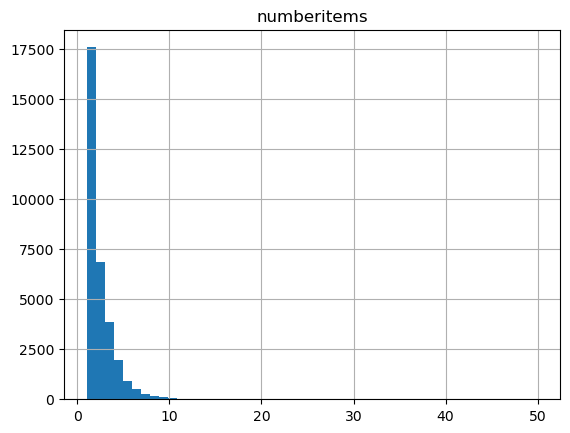

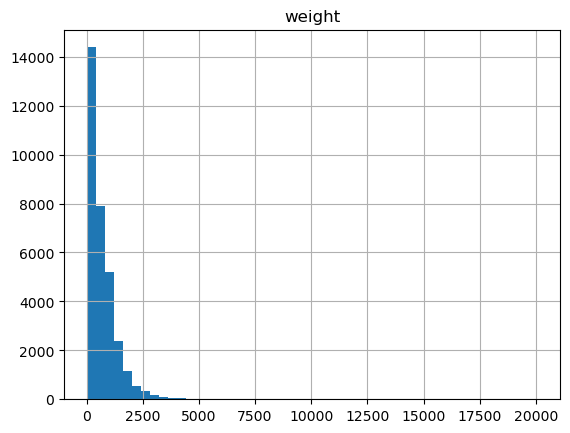

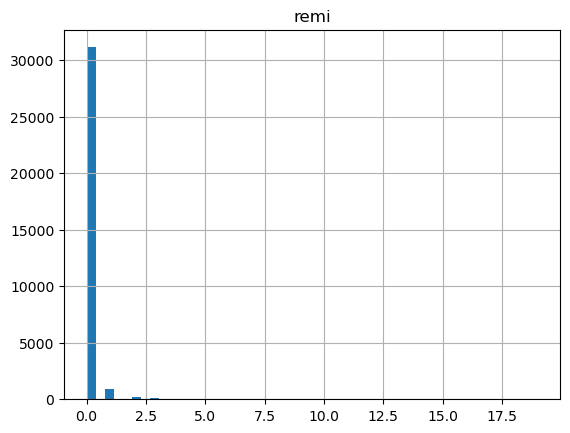

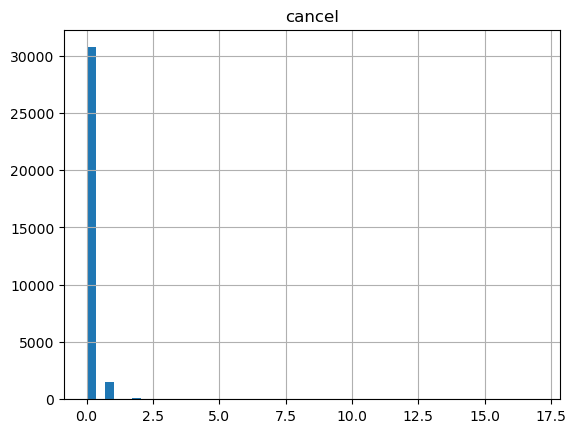

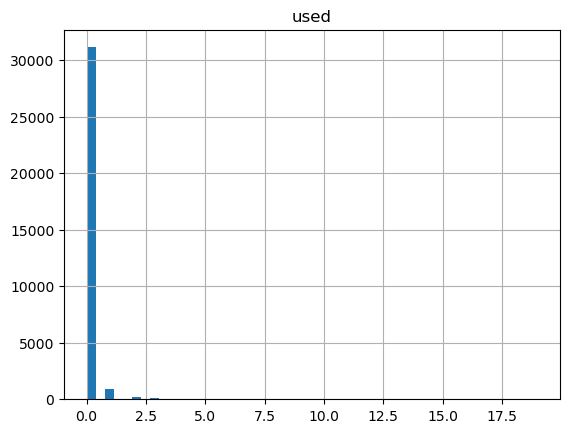

In [90]:
plot_cols = [c for c in ["numberitems", "weight", "remi", "cancel", "used"] if c in train.columns]

for c in plot_cols:
    plt.figure()
    train[c].hist(bins=50)
    plt.title(c)
    plt.show()


## 1.8 Categorical checks

We inspect low-cardinality categorical variables to confirm coding and spot rare categories.


In [91]:
cat_candidates = ["salutation", "title", "newsletter", "model", "paymenttype", "deliverytype", "voucher", "gift", "entry", "points", "shippingcosts", "domain", "case"]
for c in [x for x in cat_candidates if x in train.columns]:
    print("\n", c)
    print(train[c].value_counts(dropna=False).head(20))



 salutation
salutation
0    17840
1    11614
2     2974
Name: count, dtype: int64

 title
title
0    32202
1      226
Name: count, dtype: int64

 newsletter
newsletter
0    26932
1     5496
Name: count, dtype: int64

 model
model
1    18808
3     7358
2     6262
Name: count, dtype: int64

 paymenttype
paymenttype
0    15063
1     6549
2     6537
3     4279
Name: count, dtype: int64

 deliverytype
deliverytype
0    25879
1     6549
Name: count, dtype: int64

 voucher
voucher
0    27174
1     5254
Name: count, dtype: int64

 gift
gift
0    32280
1      148
Name: count, dtype: int64

 entry
entry
0    18982
1    13446
Name: count, dtype: int64

 points
points
0    32428
Name: count, dtype: int64

 shippingcosts
shippingcosts
0    27544
1     4884
Name: count, dtype: int64

 domain
domain
12    7734
9     6953
4     6627
8     3694
11    1422
5     1311
2     1196
0     1173
1     1139
6      548
3      381
10     137
7      113
Name: count, dtype: int64

 case
case
4    8648
3    7125
1 

## 1.10 EDA conclusions

The dataset is moderately imbalanced (≈18.7% positive class), contains strong sparsity in some variables, and shows heavy skew and outliers in count-based features.


## 2. Visual exploratory analysis

We visualize selected raw variables to motivate later preprocessing and feature engineering choices.



### 2.1 Target distribution

We confirm class imbalance to justify revenue-based optimization rather than accuracy.


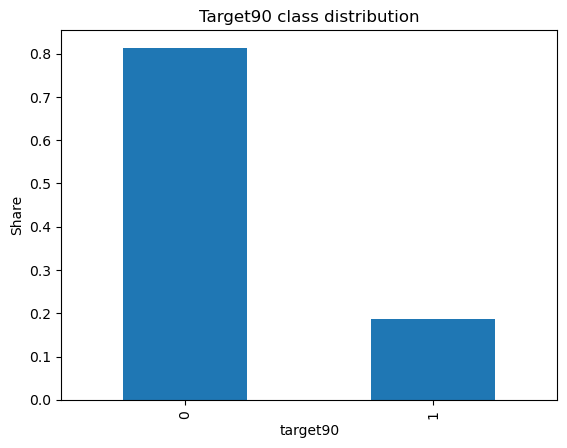

In [92]:
train["target90"].value_counts(normalize=True).plot(
    kind="bar",
    title="Target90 class distribution"
)
plt.ylabel("Share")
plt.show()


### 2.2 Account tenure and reorder behavior

Customer tenure is expected to proxy loyalty and experience.

<Figure size 640x480 with 0 Axes>

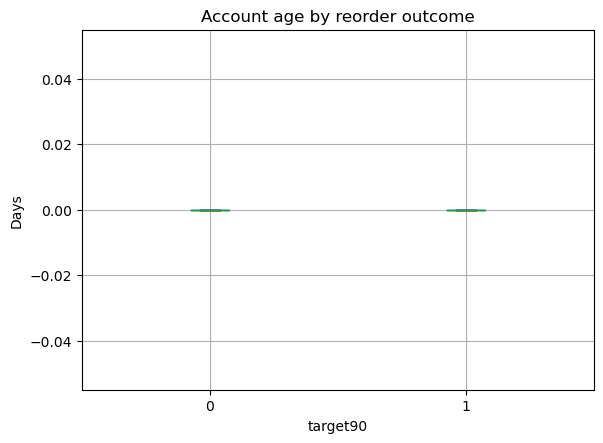

In [93]:
account_age_raw = (
    pd.to_datetime(train["date"], errors="coerce")
    - pd.to_datetime(train["datecreated"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "account_age_days": account_age_raw,
    "target90": train["target90"]
}).boxplot(
    column="account_age_days",
    by="target90",
    showfliers=False
)
plt.title("Account age by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.3 Order size and shipment weight

These variables are highly skewed and may influence reorder probability.


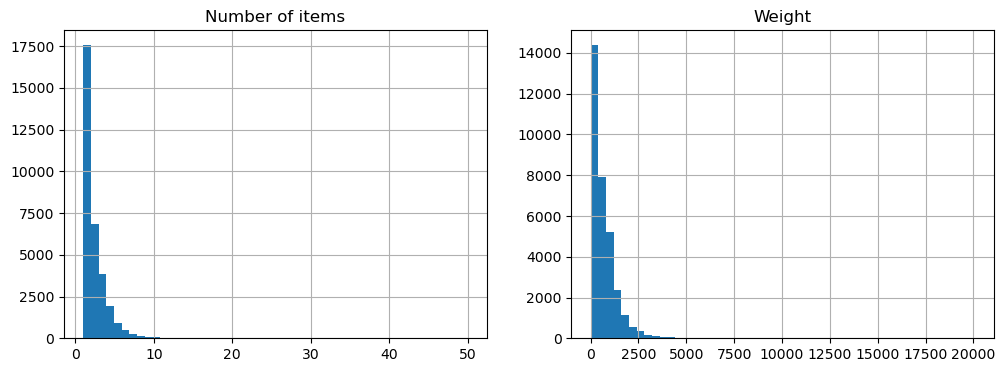

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train["numberitems"].hist(bins=50, ax=axes[0])
axes[0].set_title("Number of items")

train["weight"].hist(bins=50, ax=axes[1])
axes[1].set_title("Weight")

plt.show()


### 2.4 Product-category purchase patterns

Most category counts are sparse with long tails.



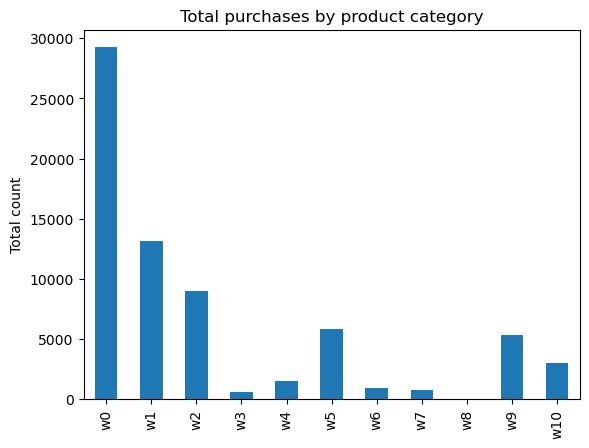

In [95]:
w_cols = [f"w{i}" for i in range(11)]

train[w_cols].sum().plot(
    kind="bar",
    title="Total purchases by product category"
)
plt.ylabel("Total count")
plt.show()



### 2.5 Promised delivery timing

Delivery expectations may influence customer satisfaction and repeat purchases.


<Figure size 640x480 with 0 Axes>

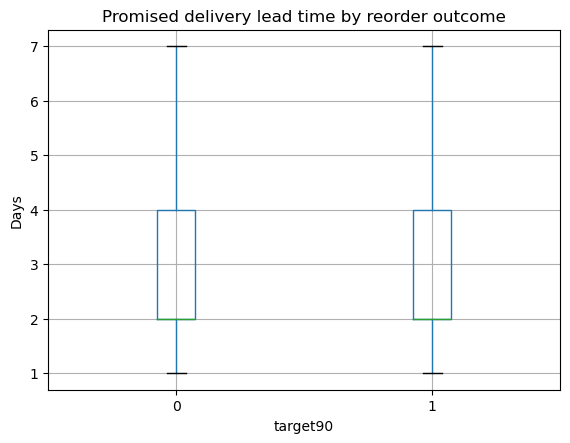

In [96]:
promised_lead_time_raw = (
    pd.to_datetime(train["deliverydatepromised"], errors="coerce")
    - pd.to_datetime(train["date"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "promised_lead_time": promised_lead_time_raw,
    "target90": train["target90"]
}).boxplot(
    column="promised_lead_time",
    by="target90",
    showfliers=False
)
plt.title("Promised delivery lead time by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.6 Incentives and service indicators

We inspect whether basic service and incentive variables differ by reorder behavior.


In [97]:
cat_vars = [
    "salutation", "title", "domain", "newsletter", "model",
    "paymenttype", "deliverytype", "voucher", "gift",
    "entry", "shippingcosts", "case"
]

for c in cat_vars:
    print(c, train[c].nunique())


salutation 3
title 2
domain 13
newsletter 2
model 3
paymenttype 4
deliverytype 2
voucher 2
gift 2
entry 2
shippingcosts 2
case 5


## 3. Data transformations and feature engineering

We construct a leakage-safe baseline feature set and clearly separate optional transformations for later robustness checks.


### 3.1 Feature removal (baseline)

We remove identifiers, constant variables, and features with extreme missingness or leakage risk.


In [98]:
# Copy to avoid modifying raw inspection data
data_fe = train.copy()

# Drop identifier
data_fe.drop(columns=["customernumber"], inplace=True)

# Drop constant feature
data_fe.drop(columns=["points"], inplace=True)

# Drop unusable postcode
data_fe.drop(columns=["delivpostcode"], inplace=True)




### 3.2 Advertising exposure indicator

We retain only the presence of advertising information, not the raw code.


In [99]:
data_fe["has_ad_code"] = data_fe["advertisingdatacode"].notna().astype(int)
data_fe.drop(columns=["advertisingdatacode"], inplace=True)


We believe missingness here can be informative. Raw advertising codes are high-cardnality and sparse

### 3.3 Date parsing

We convert date columns to datetime to enable duration and calendar features.


In [100]:
date_cols = ["date", "datecreated", "deliverydatepromised","deliverydatereal" ]

for c in date_cols:
    data_fe[c] = pd.to_datetime(data_fe[c], errors="coerce")


### 3.4 Time-based features

We extract interpretable duration and calendar features known at order time.


In [101]:
# Customer tenure
data_fe["account_age_days"] = (data_fe["date"] - data_fe["datecreated"]).dt.days

# Order timing
data_fe["order_weekday"] = data_fe["date"].dt.weekday
data_fe["order_month"] = data_fe["date"].dt.month

# Promised delivery timing
data_fe["promised_delivery_weekday"] = data_fe["deliverydatepromised"].dt.weekday
data_fe["promised_delivery_month"] = data_fe["deliverydatepromised"].dt.month

# Promised lead time
data_fe["delivery_difference"] = (
    data_fe["deliverydatereal"] - data_fe["deliverydatepromised"]
).dt.days


### 3.5 Drop raw date variables

After feature extraction, raw datetime columns are no longer needed.


In [102]:
data_fe.drop(columns=["date", "datecreated", "deliverydatepromised","deliverydatereal"], inplace=True)


### 3.6 Product-category aggregation

We summarize sparse product-category counts into a single diversity measure.


In [103]:
w_cols = [f"w{i}" for i in range(11)]
data_fe["product_diversity"] = (data_fe[w_cols] > 0).sum(axis=1)


this reduces dimensionality and preserves signal on breath of engagement

In [104]:
data_fe.isna().sum().sort_values(ascending=False)

delivery_difference          5478
promised_delivery_month         9
promised_delivery_weekday       9
salutation                      0
w9                              0
w3                              0
w4                              0
w5                              0
w6                              0
w7                              0
w8                              0
target90                        0
w10                             0
title                           0
has_ad_code                     0
account_age_days                0
order_weekday                   0
order_month                     0
w2                              0
w1                              0
w0                              0
used                            0
domain                          0
newsletter                      0
model                           0
paymenttype                     0
deliverytype                    0
invoicepostcode                 0
voucher                         0
case          

## 3.7 Outsert the missings 

In [105]:
delay_median = data_fe["delivery_difference"].median()
data_fe["delivery_difference"].fillna(delay_median, inplace=True)

In [106]:
# we just need the mode for the other variables because the 9 observations are purely negligable
for col in ["promised_delivery_month",
            "promised_delivery_weekday"]:
    data_fe[col].fillna(data_fe[col].mode()[0], inplace=True)

## 3.8 Check all data types

In [107]:
data_types = pd.DataFrame({
    "column": data_fe.columns,
    "dtype" : data_fe.dtypes.values
})
data_types

,column,dtype
0,salutation,int64
1,title,int64
2,domain,int64
3,newsletter,int64
4,model,int64
5,paymenttype,int64
6,deliverytype,int64
7,invoicepostcode,int64
8,voucher,int64
9,case,int64


In [108]:
# save features as categorical
data_fe['salutation'] = data_fe['salutation'].astype('category')
data_fe['paymenttype'] = data_fe['paymenttype'].astype('category')
data_fe['deliverytype'] = data_fe['deliverytype'].astype('category')
data_fe['entry'] = data_fe['entry'].astype('category')

# handling ordinal data
data_fe['case'].unique()
cases=1,2,3,4,5
data_fe['case'] = data_fe['case'].astype('category')
data_fe['case'] = data_fe['case'].cat.set_categories(cases, ordered=True)
data_fe['case'].unique()

[2, 1, 3, 4, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

## 3.9 Feature creation 

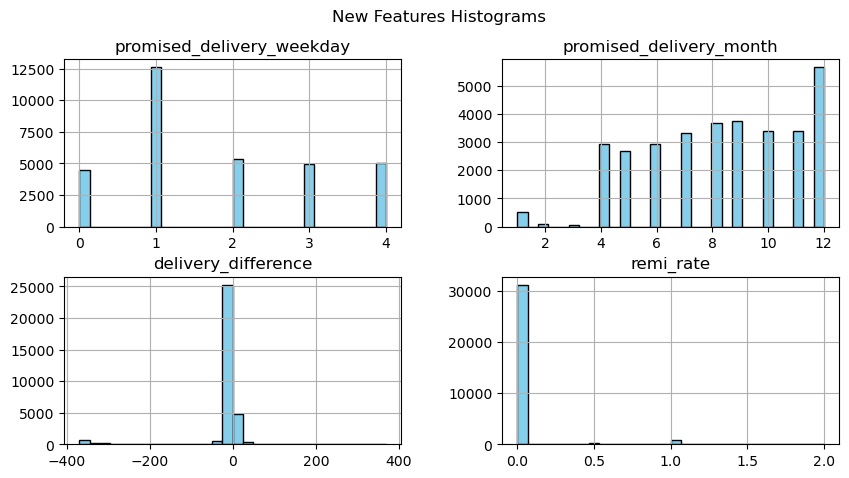

In [109]:
data_fe['remi_rate']=data_fe['remi']/data_fe['numberitems']


# Analyze the new features
new_features = data_fe.select_dtypes(include=['float64']).columns

# Plot histograms for the new features
data_fe[new_features].hist(bins=30, figsize=(10, 5), color='skyblue', edgecolor='black')
plt.suptitle('New Features Histograms', fontsize=12)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

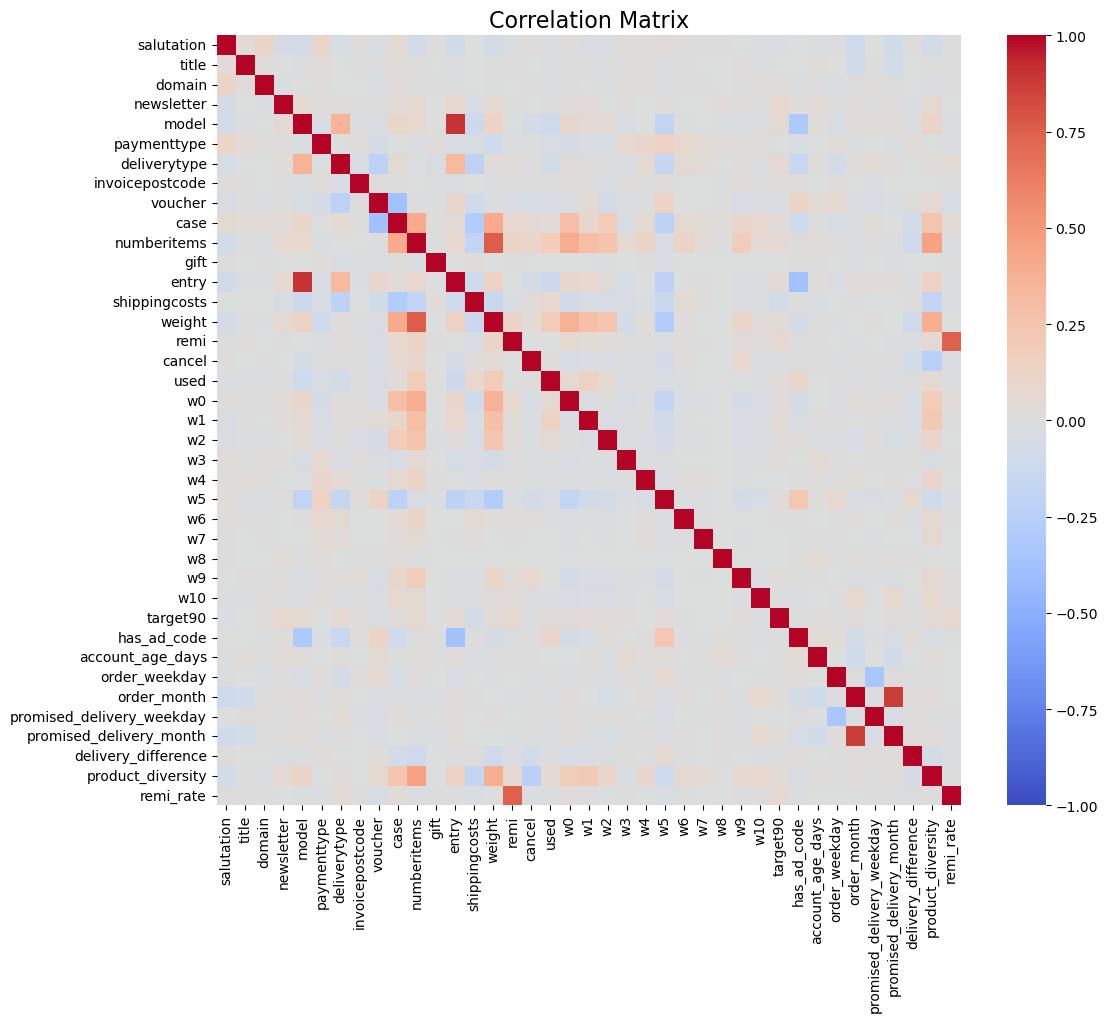

In [110]:
import seaborn as sns
# Correlation matrix 
corr_matrix = data_fe.corr()
corr_matrix

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title("Correlation Matrix", fontsize=16)
plt.show

## 3. Data transformations and feature engineering (implemented)

This section documents the feature engineering steps applied to the raw training data prior to building the preprocessing pipeline.

### 3.1 Column removals (data cleaning)
- **Dropped `customernumber`**: identifier only; not meaningful as a predictive feature.
- **Dropped `points`**: constant (zero variance), therefore no predictive value.
- **Dropped `delivpostcode`**: ~95% missingness; too sparse to be informative without heavy imputation.

### 3.2 Advertising information (missingness signal)
- **Created `has_ad_code` = 1 if `advertisingdatacode` is present else 0**, then dropped `advertisingdatacode`.
  - Rationale: the *presence* of tracking information can carry behavioral/marketing signal, while the raw code is high-cardinality and mostly missing.

### 3.3 Datetime conversion (enables time-based features)
Converted the following columns to datetime using `errors="coerce"`:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: ensures consistent parsing and gracefully handles invalid date entries by converting them to `NaT`.

### 3.4 Time-derived customer and order features
Engineered the following features from `date` and `datecreated`:
- **`account_age_days` = `date` − `datecreated`**  
  - Rationale: proxies tenure/relationship maturity, often correlated with retention.
- **`order_weekday`** (0–6) and **`order_month`** (1–12) from `date`  
  - Rationale: captures seasonality and weekday behavioral patterns.

### 3.5 Delivery timing feature
Engineered:
- **`delivery_difference` = `deliverydatereal` − `deliverydatepromised` (days)**  
  - Rationale: delivery experience may affect customer satisfaction and reorder propensity.

After feature extraction, dropped raw datetime columns:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: avoids redundancy and prevents downstream models from using raw timestamps directly.

### 3.6 Product-category aggregation
Created:
- **`product_diversity` = number of product-category counts `w0..w10` that are > 0**
  - Rationale: compresses sparse category information into an interpretable breadth-of-purchase metric while reducing dimensionality.

### 3.7 Missing value handling (post-engineering)
Observed missingness after engineering:
- `delivery_difference`: 5,478 missing (from invalid/missing coerced datetimes)
- `promised_delivery_month`: 9 missing
- `promised_delivery_weekday`: 9 missing

Imputation applied:
- **`delivery_difference` filled with median**
  - Rationale: median is robust to heavy tails and outliers in delay distributions.
- **`promised_delivery_month` and `promised_delivery_weekday` filled with mode**
  - Rationale: very few missing values; mode maintains the most common calendar pattern without distorting scale.

### 3.8 Resulting feature set (current schema)
After transformations, the dataset contains:
- Original integer-coded categorical features: `salutation`, `title`, `domain`, `newsletter`, `model`, `paymenttype`, `deliverytype`, `invoicepostcode`, `voucher`, `case`, `gift`, `entry`, `shippingcosts`
- Numeric/count features: `numberitems`, `weight`, `remi`, `cancel`, `used`, `w0..w10`
- Engineered features: `has_ad_code`, `account_age_days`, `order_weekday`, `order_month`, `promised_delivery_weekday`, `promised_delivery_month`, `delivery_difference`, `product_diversity`
- Target: `target90`

---

## Reversible design choices (for robustness checks)

The following transformations are plausible but not fully “locked in” and should be evaluated via validation expected revenue:

- **[OPTION] Use of `delivery_difference` (derived from `deliverydatereal`)**
  - Risk: potential leakage if voucher decisions occur before real delivery outcomes are known.
  - Robustness test: compare baseline (drop `deliverydatereal`-derived features) vs. variant (include `delivery_difference`).

- **[OPTION] Representation of product-category variables (`w0..w10`)**
  - Variant A: use only raw `w0..w10`
  - Variant B: use only `product_diversity`
  - Variant C: use both
  - Rationale: different representations trade off dimensionality vs. signal.

- **[OPTION] Treat `invoicepostcode` as categorical vs. numeric**
  - Baseline suggestion: one-hot encode (≈100 categories)
  - Variant: keep numeric for tree models (may impose artificial ordering)

- **[OPTION] Transform heavy-tailed numeric variables**
  - Candidates: `weight`, `numberitems`, potentially `w0..w10`
  - Variant: apply `log1p` for linear models or calibration sensitivity checks.

These options will be tracked explicitly and compared under the business objective (expected revenue), not accuracy.


## Parts I am not pretty sure abozt that maybe have flaws
These should be integers: salutation, title, domain, newsletter, model, paymenttype, deliverytype, voucher, gift, entry, shippingcosts

What I would leave the way it is : case;
option here though could be to one hot encode it 

this hsould be categorical : invoicepostcode (0–99): should be categorical.


Moroever, I would keep w0..w10 and product_diversity




In [111]:
# Importnat those categorical variables that I created and should be preserved
for c in ["promised_delivery_weekday", "promised_delivery_month"]:
    data_fe[c] = data_fe[c].astype(int)

data_fe.drop(columns=["invoicepostcode"], inplace=True)

# 4. Data splitting and one-hot encoding

In [112]:
from sklearn.model_selection import train_test_split

X = data_fe.drop(columns=["target90"])
y = data_fe["target90"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## 4.1 One hot encoding

In [113]:
w_cols = [f"w{i}" for i in range(11)]

cat_cols = [
    "salutation","title","domain","newsletter","model",
    "paymenttype","deliverytype","voucher","gift","entry",
    "shippingcosts"
   
]

num_cols = [
    "case",  # keep ordinal in baseline
    "numberitems","weight","remi","cancel","used",
    "has_ad_code","account_age_days","order_weekday","order_month",
    "promised_delivery_weekday","promised_delivery_month",
    "delivery_difference","product_diversity", "remi_rate", 
    *w_cols
]


In [114]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


### 4.2 Preprocessing sanity checks

We confirm that preprocessing produces consistent feature matrices for train and validation.


In [115]:
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)

X_train_t.shape, X_val_t.shape


((24321, 63), (8107, 63))

In [116]:
# Numeric names are unchanged
num_names = num_cols

# One-hot names for categoricals
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()

feature_names = num_names + cat_names
len(feature_names), X_train_t.shape[1]


(63, 63)

In [117]:
# create the final datasets
X_train_df = pd.DataFrame(
    X_train_t,
    columns=feature_names,
    index=X_train.index
)

X_val_df = pd.DataFrame(
    X_val_t,
    columns=feature_names,
    index=X_val.index
)


In [118]:
X_train_df.shape, X_val_df.shape


((24321, 63), (8107, 63))

In [119]:
X_train_df.isna().sum().sum(), X_val_df.isna().sum().sum()
# did any kind of missings snuck in ?


(0, 0)

## 5. Applying transformations to the test set

We apply the exact same feature engineering and fitted preprocessing steps to the test data to ensure consistency.


In [120]:
test = pd.read_csv("test.csv", sep=";")

drop remi, used und cancel?

In [121]:
import pandas as pd
import numpy as np

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the project's feature engineering steps to a raw dataframe.
    This function does NOT mutate the input.
    """
    out = df.copy()

    # Drop columns we decided not to use
    out.drop(columns=["customernumber", "points", "delivpostcode"], inplace=True, errors="ignore")

    # Advertising indicator (presence only)
    if "advertisingdatacode" in out.columns:
        out["has_ad_code"] = out["advertisingdatacode"].notna().astype(int)
        out.drop(columns=["advertisingdatacode"], inplace=True)

    # Parse datetime columns
    for c in ["date", "datecreated", "deliverydatepromised", "deliverydatereal"]:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")

    # Engineered time features
    out["account_age_days"] = (out["date"] - out["datecreated"]).dt.days
    out["order_weekday"] = out["date"].dt.weekday
    out["order_month"] = out["date"].dt.month

    out["promised_delivery_weekday"] = out["deliverydatepromised"].dt.weekday
    out["promised_delivery_month"] = out["deliverydatepromised"].dt.month

    # Delivery difference (OPTION: potentially leaky)
    out["delivery_difference"] = (out["deliverydatereal"] - out["deliverydatepromised"]).dt.days
    # Rates
    out['remi_rate'] = out['remi'] / out['numberitems']

    # Drop raw datetime columns
    out.drop(
        columns=["date", "datecreated", "deliverydatepromised", "deliverydatereal"],
        inplace=True,
        errors="ignore"
    )

    # Product diversity
    w_cols = [f"w{i}" for i in range(11)]
    existing_w = [c for c in w_cols if c in out.columns]
    out["product_diversity"] = (out[existing_w] > 0).sum(axis=1)

    # Your latest choice: drop invoicepostcode to keep features <= ~65
    out.drop(columns=["invoicepostcode"], inplace=True, errors="ignore")

    # Ensure discrete engineered features are integers where possible (NaNs handled later by imputers)
    # We'll cast after imputation in the pipeline, but keeping them numeric is fine here.

    return out


In [122]:
test_fe = engineer_features(test)

In [123]:
X_test_t = preprocess.transform(test_fe)

In [124]:
X_test_df = pd.DataFrame(
    X_test_t,
    columns=feature_names,
    index=test_fe.index
)


In [125]:
missing = [c for c in (num_cols + cat_cols) if c not in test_fe.columns]
extra = [c for c in test_fe.columns if c not in (num_cols + cat_cols)]
missing, extra[:20]


([], [])

In [126]:
X_test_t.shape

(32427, 63)

# ML Modeling Pipeline: Strategic Voucher Targeting

Here we implement an end-to-end modeling workflow for maximizing expected revenue from sending €5 vouchers to customers after their first purchase.

**Business Objective**: Optimize the decision to send vouchers to maximize net revenue.

**Key Decision Rule**: Send voucher when predicted probability of reorder (target90=1) is **below** a threshold, i.e., send to customers predicted as **not reordering**.


## 1. Imports and Config

We import the required libraries for data handling, visualization, model training, and evaluation. We also set a fixed random seed to ensure reproducible results and use availability checks for optional packages (Optuna, XGBoost) so the notebook remains executable even if they are not installed.

In [127]:
# CELL 1 — Imports + setup (same as yours)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)


import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports completed successfully.")



Imports completed successfully.


## Checking train and test set and making sure everything is coherent before modeling 

In [128]:
try:
    _ = X_train_df.shape
    _ = X_val_df.shape
    _ = X_test_df.shape
    _ = y_train.shape
    _ = y_val.shape
    print("Using preprocessed data from memory.")
except NameError as e:
    raise NameError(
        "X_train_df / X_val_df / X_test_df / y_train / y_val not found. "
        "Run preprocessing/feature engineering first."
    ) from e

# Quality checks
assert X_train_df.columns.equals(X_val_df.columns), "Train and validation columns don't match"
assert X_val_df.columns.equals(X_test_df.columns), "Validation and test columns don't match"
assert X_train_df.isna().sum().sum() == 0, "NaNs found in X_train_df"
assert X_val_df.isna().sum().sum() == 0, "NaNs found in X_val_df"
assert X_test_df.isna().sum().sum() == 0, "NaNs found in X_test_df"

print(f"Train shape: {X_train_df.shape}")
print(f"Validation shape: {X_val_df.shape}")
print(f"Test shape: {X_test_df.shape}")
print(f"Positive class rate (train): {y_train.mean():.4f}")
print(f"Positive class rate (val): {y_val.mean():.4f}")


Using preprocessed data from memory.
Train shape: (24321, 63)
Validation shape: (8107, 63)
Test shape: (32427, 63)
Positive class rate (train): 0.1866
Positive class rate (val): 0.1866


# Revenue and Treshhold optimization

Here we translate model probabilities into business outcomes 
We define a custom revenue function that maps predicted reorder probabilities to voucher decisions and monetary outcomes. A voucher is sent only when the predicted probability of reordering is sufficiently low. Since sending a voucher has asymmetric gains and losses, we optimize the probability threshold on the validation set to maximize total expected revenue rather than relying on a fixed classification threshold.

In [129]:
# Revenue and Treshhold calculation
def calculate_revenue(y_true, y_pred_proba, threshold):
    """
    Decision rule: send_voucher = 1 if p(reorder=1) < threshold else 0
    
    Revenue:
    - send & y==0 => +1.25
    - send & y==1 => -5
    - else => 0
    """
    y_true = np.asarray(y_true)
    y_pred_proba = np.asarray(y_pred_proba)

    send_voucher = (y_pred_proba < threshold).astype(int)

    revenue = np.zeros(len(y_true))
    revenue[(send_voucher == 1) & (y_true == 0)] = 1.25
    revenue[(send_voucher == 1) & (y_true == 1)] = -5.0

    total_revenue = revenue.sum()
    avg_revenue = total_revenue / len(y_true)

    return total_revenue, avg_revenue, send_voucher


def optimize_threshold(y_true, y_pred_proba, threshold_range=None):
    if threshold_range is None:
        threshold_range = np.linspace(0.01, 0.99, 99)

    rows = []
    for t in threshold_range:
        total_rev, avg_rev, _ = calculate_revenue(y_true, y_pred_proba, t)
        rows.append({"threshold": t, "total_revenue": total_rev, "avg_revenue": avg_rev})

    df = pd.DataFrame(rows)
    best_idx = df["total_revenue"].idxmax()
    return float(df.loc[best_idx, "threshold"]), float(df.loc[best_idx, "total_revenue"]), df


print("Revenue function sanity test:")
test_y = np.array([0, 0, 1, 1])
test_p = np.array([0.1, 0.9, 0.1, 0.9])
t = 0.5
tot, avg, send = calculate_revenue(test_y, test_p, t)
print("send:", send, "total:", tot, "avg:", avg)


Revenue function sanity test:
send: [1 0 1 0] total: -3.75 avg: -0.9375


The negative revenue in the sanity test confirms that sending vouchers based on an arbitrary probability threshold can be unprofitable, especially when vouchers are sent to customers who would have reordered anyway. This motivates optimizing the decision threshold based on expected revenue rather than using a fixed cutoff.


## Evaluation code
We first evaluate models using standard classification metrics at the default decision threshold to ensure comparability with classical machine-learning benchmarks. Revenue optimization is then performed separately using predicted probabilities and a business-specific decision rule.


In [130]:

models = {}
results = []

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Reorder", "Reorder"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)

    # Default label predictions (diagnostic only)
    y_pred_default = model.predict(X_val)

    # Probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]  # P(reorder=1)
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X_val)
        y_proba = 1 / (1 + np.exp(-s))
    else:
        y_proba = y_pred_default.astype(float)

    y_proba = np.clip(y_proba, 0, 1)

    # Standard metrics at default threshold (optional)
    acc = accuracy_score(y_val, y_pred_default)
    prec = precision_score(y_val, y_pred_default, zero_division=0)
    rec = recall_score(y_val, y_pred_default, zero_division=0)
    f1 = f1_score(y_val, y_pred_default, zero_division=0)
    auc = roc_auc_score(y_val, y_proba)

    # Optimize business threshold
    best_t, best_rev, rev_curve = optimize_threshold(y_val, y_proba)

    # Decision under best threshold:
    # predict reorder=1 if proba >= t else 0
    y_pred_best_t = (y_proba >= best_t).astype(int)

    # Voucher action: send if proba < t
    send_voucher = (y_proba < best_t).astype(int)

    # Revenue at best threshold (uses send rule internally)
    total_rev, avg_rev, _ = calculate_revenue(y_val, y_proba, best_t)

    return {
        "model_name": model_name,

        # Diagnostics (default predict)
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "report_default": classification_report(
            y_val, y_pred_default,
            target_names=["No Reorder", "Reorder"],
            zero_division=0
        ),
        "y_pred_default": y_pred_default,

        # Business / decision outputs
        "best_threshold": best_t,
        "total_revenue": total_rev,
        "avg_revenue": avg_rev,
        "send_rate": float(send_voucher.mean()),
        "y_pred_best_t": y_pred_best_t,
        "send_voucher": send_voucher,

        # Keep these for plotting/analysis
        "y_proba": y_proba,
        "rev_curve": rev_curve,
    }, model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_action_cm(y_true, send_voucher, title):
    """
    Action confusion matrix:
    rows = true label (0=No Reorder, 1=Reorder)
    cols = action (0=No Send, 1=Send)
    """
    cm = confusion_matrix(y_true, send_voucher, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Send", "Send"])
    disp.plot(values_format="d")
    plt.title(title)
    plt.xlabel("Action")
    plt.ylabel("True label (0=No Reorder, 1=Reorder)")
    plt.tight_layout()
    plt.show()



# 5. Models that are being used
## 5.1 Baseline Model
We evaluate simple, non-model-based voucher strategies (always send, never send, random send) to establish economic reference points. These baselines allow us to verify that any machine-learning model provides value beyond trivial or risk-free policies.


In [131]:
# CELL 4 — Baselines
def baseline_always_send(y_true):
    y_true = np.asarray(y_true)
    n0 = (y_true == 0).sum()
    n1 = (y_true == 1).sum()
    total = n0 * 1.25 + n1 * (-5.0)
    return total, total / len(y_true)

def baseline_never_send(y_true):
    return 0.0, 0.0

def baseline_random(y_true, p_send=0.5, random_state=RANDOM_STATE):
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true)
    send = rng.binomial(1, p_send, size=len(y_true))
    rev = np.zeros(len(y_true))
    rev[(send == 1) & (y_true == 0)] = 1.25
    rev[(send == 1) & (y_true == 1)] = -5.0
    total = rev.sum()
    return total, total / len(y_true)

print("Baselines on validation:")
for name, fn in [
    ("Always Send", baseline_always_send),
    ("Never Send", baseline_never_send),
]:
    total, avg = fn(y_val)
    print(f"{name:12s}  total=€{total:8.2f}   avg=€{avg:6.4f}")

total, avg = baseline_random(y_val, p_send=0.5)
print(f"{'Random 50%':12s}  total=€{total:8.2f}   avg=€{avg:6.4f}")


Baselines on validation:
Always Send   total=€  677.50   avg=€0.0836
Never Send    total=€    0.00   avg=€0.0000
Random 50%    total=€  366.25   avg=€0.0452


- Always Send makes money, but at high risk and low efficiency.

- Never Send is safe but leaves money on the table.

- Random is worse than Always Send, but still positive due to class imbalance.

- Any ML model must outperform €677.50 on validation to be considered useful.

,policy,total_revenue,avg_revenue
0,Always Send,677.50,0.083570
1,Never Send,0.00,0.000000
2,Random 50%,366.25,0.045177


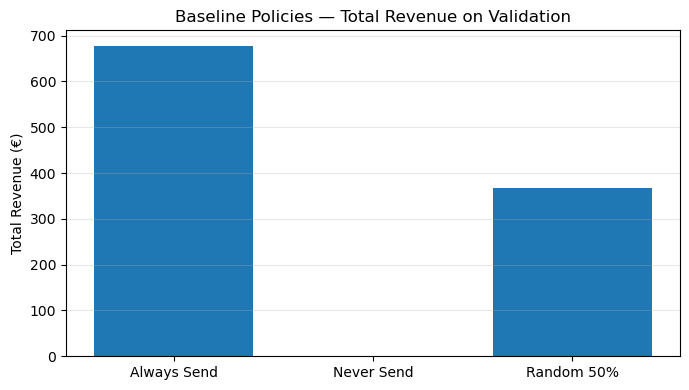

In [132]:
baseline_rows = []
for name, fn in [
    ("Always Send", baseline_always_send),
    ("Never Send", baseline_never_send),
]:
    total, avg = fn(y_val)
    baseline_rows.append({"policy": name, "total_revenue": total, "avg_revenue": avg})

# Random baseline (single run)
total, avg = baseline_random(y_val, p_send=0.5)
baseline_rows.append({"policy": "Random 50%", "total_revenue": total, "avg_revenue": avg})

baseline_df = pd.DataFrame(baseline_rows)
display(baseline_df)

plt.figure(figsize=(7,4))
plt.bar(baseline_df["policy"], baseline_df["total_revenue"])
plt.title("Baseline Policies — Total Revenue on Validation")
plt.ylabel("Total Revenue (€)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# 5.Models 

## 5.1 Logistic Regression 


Training & Evaluating: Logistic Regression
ROC-AUC (prob ranking): 0.6209
Best threshold (revenue): 0.5600
Send-rate @ best t: 0.782
Total revenue @ best t: €1720.00
Avg revenue @ best t: €0.2122

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.84      0.81      0.83      6594
     Reorder       0.29      0.34      0.32      1513

    accuracy                           0.72      8107
   macro avg       0.57      0.58      0.57      8107
weighted avg       0.74      0.72      0.73      8107



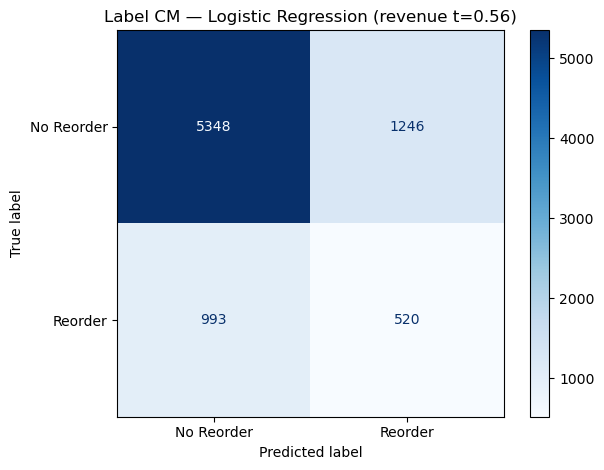

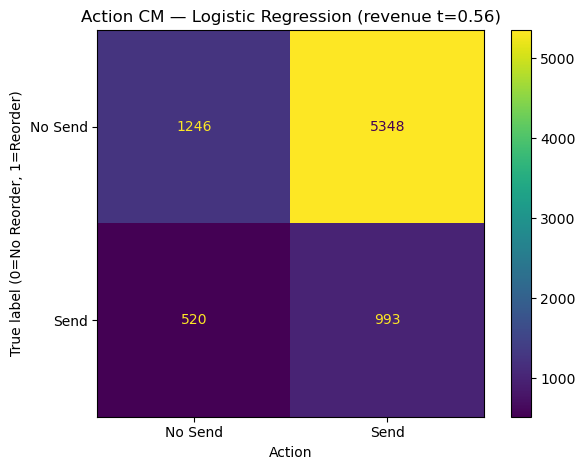

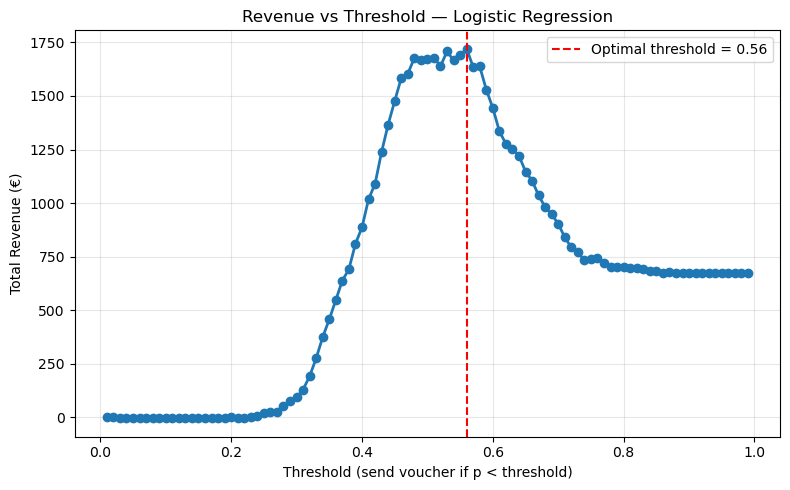

In [133]:
print("\n" + "="*80)
print("Training & Evaluating: Logistic Regression")
print("="*80)

lr = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=5000,
    class_weight="balanced",
    solver="liblinear"
)

res_lr, mdl_lr = evaluate_model(lr, "Logistic Regression", X_train_df, y_train, X_val_df, y_val)
models["Logistic Regression"] = mdl_lr
results.append(res_lr)

# --- Core business summary ---
print(f"ROC-AUC (prob ranking): {res_lr['roc_auc']:.4f}")
print(f"Best threshold (revenue): {res_lr['best_threshold']:.4f}")
print(f"Send-rate @ best t: {res_lr['send_rate']:.3f}")
print(f"Total revenue @ best t: €{res_lr['total_revenue']:.2f}")
print(f"Avg revenue @ best t: €{res_lr['avg_revenue']:.4f}")

# --- Classification report at DEPLOYED threshold (best_t) ---
print("\nClassification report at revenue-optimal threshold:")
print(classification_report(
    y_val,
    res_lr["y_pred_best_t"],
    target_names=["No Reorder", "Reorder"],
    zero_division=0
))

# --- Label CM at deployed threshold ---
plot_cm(
    y_val,
    res_lr["y_pred_best_t"],
    f"Label CM — Logistic Regression (revenue t={res_lr['best_threshold']:.2f})"
)

# --- Action CM at deployed threshold (business CM) ---
plot_action_cm(
    y_val,
    res_lr["send_voucher"],   # use returned key
    f"Action CM — Logistic Regression (revenue t={res_lr['best_threshold']:.2f})"
)

# --- Revenue curve plot ---
plt.figure(figsize=(8, 5))
plt.plot(res_lr["rev_curve"]["threshold"], res_lr["rev_curve"]["total_revenue"], marker="o", linewidth=2)
plt.axvline(res_lr["best_threshold"], color="red", linestyle="--",
            label=f"Optimal threshold = {res_lr['best_threshold']:.2f}")
plt.title("Revenue vs Threshold — Logistic Regression")
plt.xlabel("Threshold (send voucher if p < threshold)")
plt.ylabel("Total Revenue (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



### Interpretation of the confuison matrix for the logistic regression

0 = No reorder, 1 = reorder
**First the standard classification confusion matrix**:

- TN 5330, these are the correctly identified no-buyers
- TP 525, these are the correctly classified rebuyers
- FN  988, model thinks the no reorder but they reorder
- FP 1264, model thiks they reorder but they do not reorder 

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: shows that out of all predictions how many were correct

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 29 % and when it predicts no reorder it is correct 84%.
Of all customers we predicted would reorder, only ~29% actually reordered.

Recall (Sensitivity): Out of all positives how many did we catch
We only correctly flagged  ~35% of the people who actually reorder.



### Interpretation of the confuison matrix for the logistic regression but applied to send or not send

Here we send if the p <0.56
we do not send if the p>0.56

For 5330 they would not rebuy and we send so this is actually where we gain 1.25 each. In the 525 cell those are the people that do buy again and we dont send them so here actually we avoided unnecessary discounting. The 988 is where we always loose 5 euro as those are the people that buy again but we send the voucher nevertheless, and the 1262 are missed chances as those are people that would not buy again but we miss them.


### the optimal treshold for the logistic regression

# 5.2 Random Forest 


Training & Evaluating: Random Forest
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.86      0.69      0.77      6594
     Reorder       0.27      0.50      0.35      1513

    accuracy                           0.66      8107
   macro avg       0.57      0.60      0.56      8107
weighted avg       0.75      0.66      0.69      8107

Default metrics -> Acc: 0.6575 | Prec(1): 0.2730 | Rec(1): 0.5023 | F1(1): 0.3537 | ROC-AUC: 0.6393

Revenue-optimized decision:
Best threshold (revenue): 0.5000
Send-rate @ best t: 0.657
Total Revenue @ best t: €1947.50
Average Revenue @ best t: €0.2402


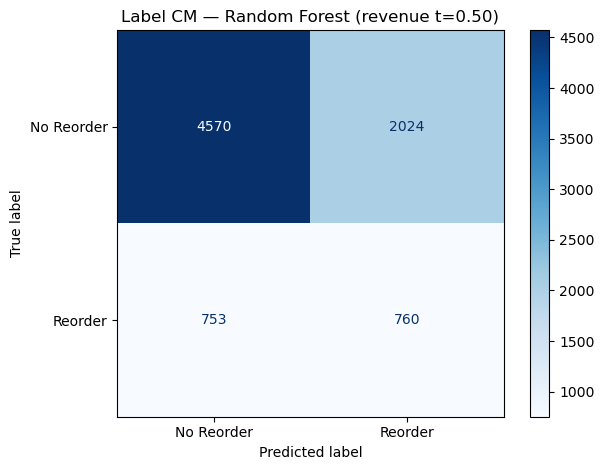

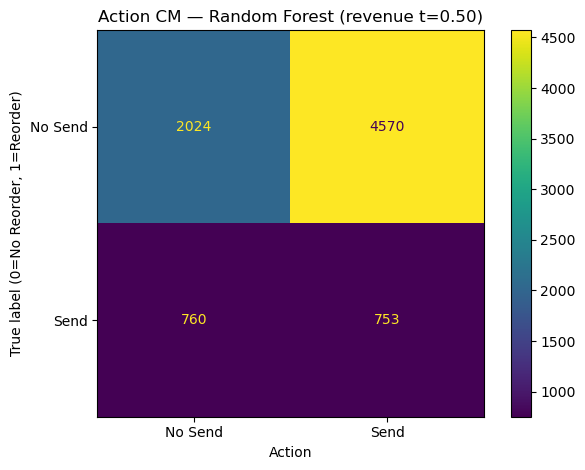

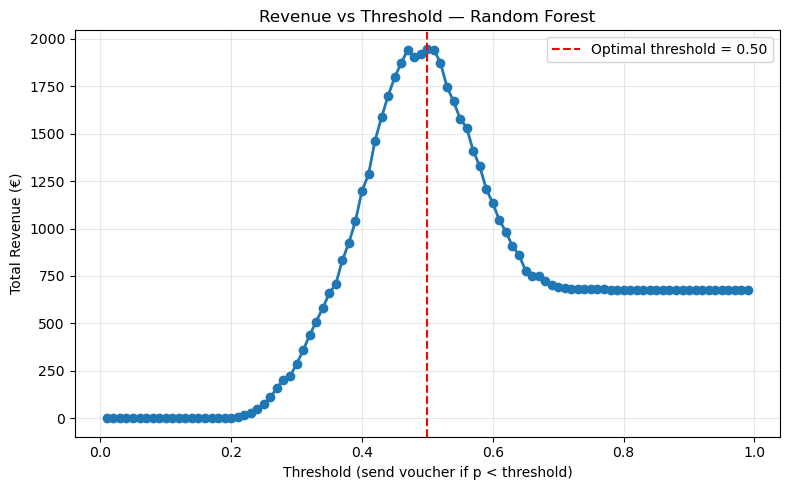

In [134]:
print("\n" + "="*80)
print("Training & Evaluating: Random Forest")
print("="*80)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

result_rf, model_rf = evaluate_model(rf, "Random Forest", X_train_df, y_train, X_val_df, y_val)
models["Random Forest"] = model_rf
results.append(result_rf)

# --- Default threshold diagnostics (optional, but useful) ---
print("Default-threshold classification report:")
print(result_rf["report_default"])
print(
    f"Default metrics -> Acc: {result_rf['accuracy']:.4f} | "
    f"Prec(1): {result_rf['precision']:.4f} | Rec(1): {result_rf['recall']:.4f} | "
    f"F1(1): {result_rf['f1']:.4f} | ROC-AUC: {result_rf['roc_auc']:.4f}"
)

# --- Business outputs (what you deploy) ---
print("\nRevenue-optimized decision:")
print(f"Best threshold (revenue): {result_rf['best_threshold']:.4f}")
print(f"Send-rate @ best t: {result_rf['send_rate']:.3f}")
print(f"Total Revenue @ best t: €{result_rf['total_revenue']:.2f}")
print(f"Average Revenue @ best t: €{result_rf['avg_revenue']:.4f}")

# --- Label CM at revenue-opt threshold ---
plot_cm(
    y_val,
    result_rf["y_pred_best_t"],
    f"Label CM — Random Forest (revenue t={result_rf['best_threshold']:.2f})"
)

# --- Action CM at revenue-opt threshold (business CM) ---
plot_action_cm(
    y_val,
    result_rf["send_voucher"],
    f"Action CM — Random Forest (revenue t={result_rf['best_threshold']:.2f})"
)

# --- Revenue curve plot ---
plt.figure(figsize=(8, 5))
plt.plot(result_rf["rev_curve"]["threshold"], result_rf["rev_curve"]["total_revenue"], marker="o", linewidth=2)
plt.axvline(result_rf["best_threshold"], color="red", linestyle="--",
            label=f"Optimal threshold = {result_rf['best_threshold']:.2f}")
plt.title("Revenue vs Threshold — Random Forest")
plt.xlabel("Threshold (send voucher if p < threshold)")
plt.ylabel("Total Revenue (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 5.3 Gradient Boosting


In [135]:
from sklearn.metrics import classification_report

def print_and_plot_result(res, model_title):
    print("\n" + "="*80)
    print(f"Training & Evaluating: {model_title}")
    print("="*80)

    # Default threshold diagnostics
    if "report_default" in res:
        print("Default-threshold classification report:")
        print(res["report_default"])
        print(
            f"Default metrics -> Acc: {res['accuracy']:.4f} | "
            f"Prec(1): {res['precision']:.4f} | Rec(1): {res['recall']:.4f} | "
            f"F1(1): {res['f1']:.4f} | ROC-AUC: {res['roc_auc']:.4f}"
        )
    else:
        print(f"ROC-AUC: {res['roc_auc']:.4f}")

    # Revenue-optimized decision
    print("\nRevenue-optimized decision:")
    print(f"Best threshold (revenue): {res['best_threshold']:.4f}")
    print(f"Send-rate @ best t: {res['send_rate']:.3f}")
    print(f"Total Revenue @ best t: €{res['total_revenue']:.2f}")
    print(f"Average Revenue @ best t: €{res['avg_revenue']:.4f}")

    # Report at deployed threshold (compute on the fly if not stored)
    print("\nClassification report at revenue-optimal threshold:")
    print(classification_report(
        y_val, res["y_pred_best_t"],
        target_names=["No Reorder", "Reorder"],
        zero_division=0
    ))

    # Plots
    plot_cm(y_val, res["y_pred_best_t"], f"Label CM — {model_title} (revenue t={res['best_threshold']:.2f})")
    plot_action_cm(y_val, res["send_voucher"], f"Action CM — {model_title} (revenue t={res['best_threshold']:.2f})")

    plt.figure(figsize=(8, 5))
    plt.plot(res["rev_curve"]["threshold"], res["rev_curve"]["total_revenue"], marker="o", linewidth=2)
    plt.axvline(res["best_threshold"], color="red", linestyle="--",
                label=f"Optimal threshold = {res['best_threshold']:.2f}")
    plt.title(f"Revenue vs Threshold — {model_title}")
    plt.xlabel("Threshold (send voucher if p < threshold)")
    plt.ylabel("Total Revenue (€)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



Training & Evaluating: Gradient Boosting
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      0.99      0.90      6594
     Reorder       0.39      0.01      0.03      1513

    accuracy                           0.81      8107
   macro avg       0.60      0.50      0.46      8107
weighted avg       0.73      0.81      0.73      8107

Default metrics -> Acc: 0.8118 | Prec(1): 0.3860 | Rec(1): 0.0145 | F1(1): 0.0280 | ROC-AUC: 0.6411

Revenue-optimized decision:
Best threshold (revenue): 0.1900
Send-rate @ best t: 0.605
Total Revenue @ best t: €1995.00
Average Revenue @ best t: €0.2461

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.87      0.64      0.74      6594
     Reorder       0.27      0.56      0.36      1513

    accuracy                           0.63      8107
   macro avg       0.57      0.60      0.55      8107
weighted a

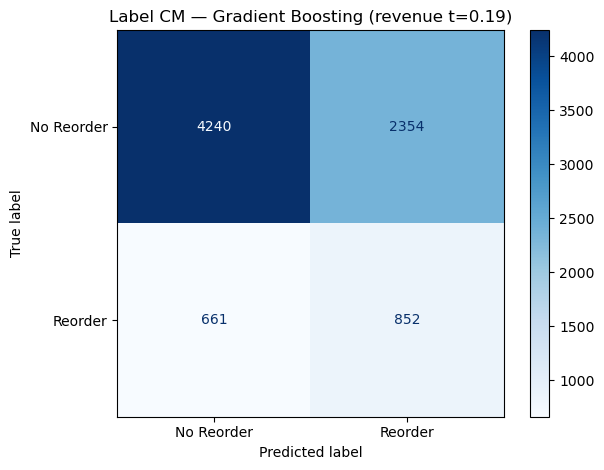

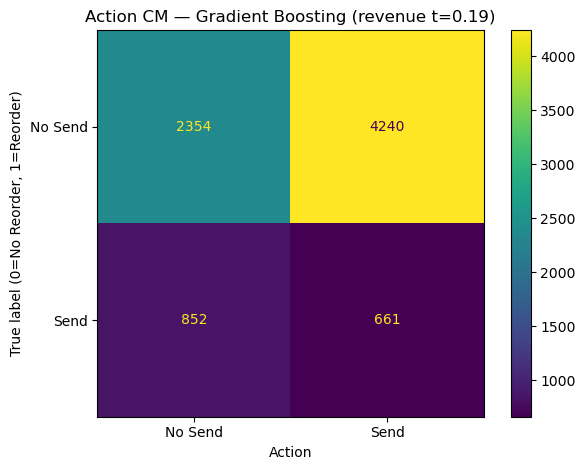

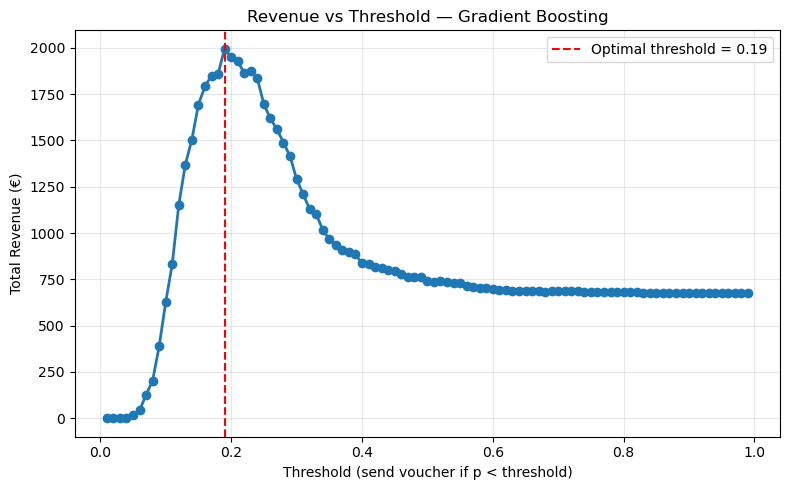

In [136]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

result_gb, model_gb = evaluate_model(gb, "Gradient Boosting", X_train_df, y_train, X_val_df, y_val)
models["Gradient Boosting"] = model_gb
results.append(result_gb)

print_and_plot_result(result_gb, "Gradient Boosting")



## 5.4 LightGBM

[LightGBM] [Info] Number of positive: 4538, number of negative: 19783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 963
[LightGBM] [Info] Number of data points in the train set: 24321, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.186588 -> initscore=-1.472337
[LightGBM] [Info] Start training from score -1.472337

Training & Evaluating: LightGBM
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.85      0.72      0.78      6594
     Reorder       0.27      0.44      0.33      1513

    accuracy                           0.67      8107
   macro avg       0.56      0.58      0.56      8107
weighted avg       0.74      0.67      0.70      8107

Default metrics -> Acc: 0.6710 | Prec(1): 0

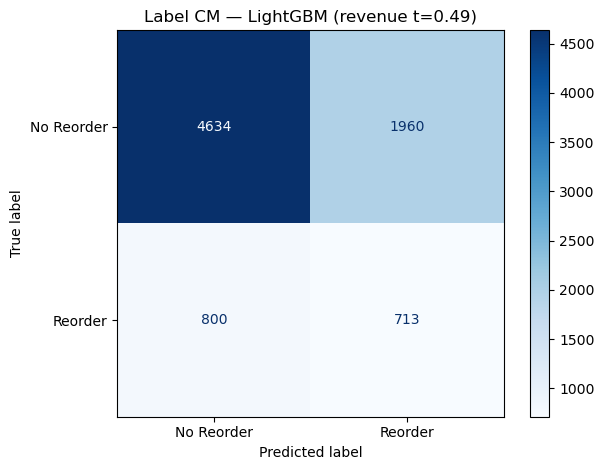

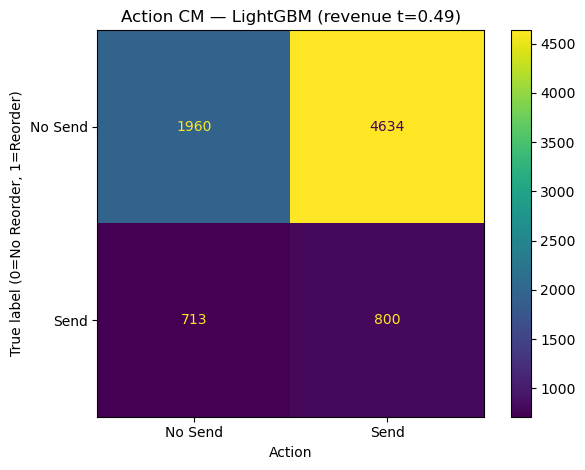

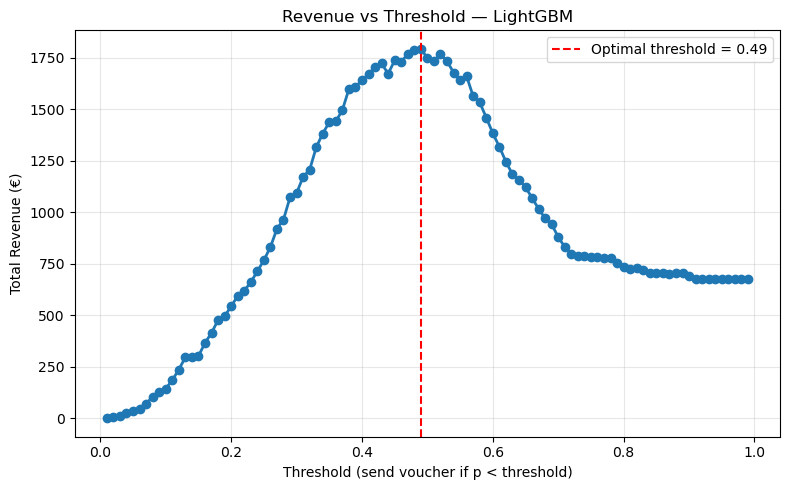

In [137]:
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False

if not LGBM_AVAILABLE:
    print("LightGBM is not installed in this environment. Skipping LightGBM.")
else:
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    spw = n_neg / n_pos

    lgbm_clf = lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        class_weight=None,
        scale_pos_weight=spw,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    result_lgbm, model_lgbm = evaluate_model(lgbm_clf, "LightGBM", X_train_df, y_train, X_val_df, y_val)
    models["LightGBM"] = model_lgbm
    results.append(result_lgbm)

    print_and_plot_result(result_lgbm, "LightGBM")


## 5.5 HistBoost



Training & Evaluating: HistGradientBoosting
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.54      0.00      0.01      1513

    accuracy                           0.81      8107
   macro avg       0.68      0.50      0.45      8107
weighted avg       0.76      0.81      0.73      8107

Default metrics -> Acc: 0.8135 | Prec(1): 0.5385 | Rec(1): 0.0046 | F1(1): 0.0092 | ROC-AUC: 0.6469

Revenue-optimized decision:
Best threshold (revenue): 0.1900
Send-rate @ best t: 0.580
Total Revenue @ best t: €2055.00
Average Revenue @ best t: €0.2535

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.87      0.62      0.72      6594
     Reorder       0.26      0.60      0.37      1513

    accuracy                           0.62      8107
   macro avg       0.57      0.61      0.55      8107
weighte

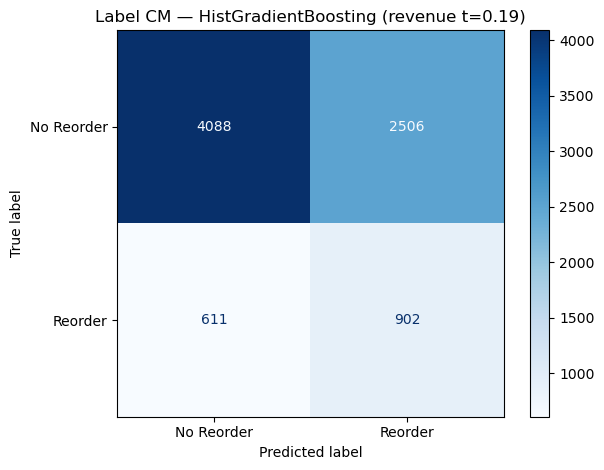

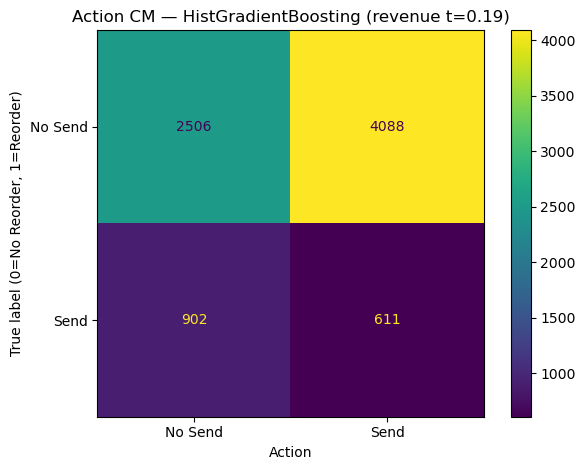

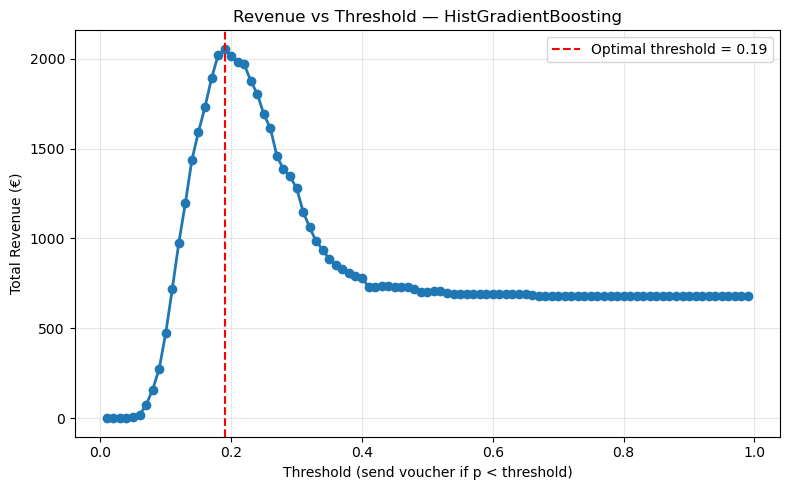

In [138]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=400,
    random_state=RANDOM_STATE
)

result_hgb, model_hgb = evaluate_model(hgb, "HistGradientBoosting", X_train_df, y_train, X_val_df, y_val)
models["HistGradientBoosting"] = model_hgb
results.append(result_hgb)

print_and_plot_result(result_hgb, "HistGradientBoosting")


## 5.5 K-Nearest Neighbors (with scaling)


Training K-Nearest Neighbors (with StandardScaler)...

Training & Evaluating: KNN
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.82      0.94      0.87      6594
     Reorder       0.26      0.10      0.14      1513

    accuracy                           0.78      8107
   macro avg       0.54      0.52      0.51      8107
weighted avg       0.72      0.78      0.74      8107

Default metrics -> Acc: 0.7808 | Prec(1): 0.2634 | Rec(1): 0.0972 | F1(1): 0.1420 | ROC-AUC: 0.5575

Revenue-optimized decision:
Best threshold (revenue): 0.2800
Send-rate @ best t: 0.753
Total Revenue @ best t: €1138.75
Average Revenue @ best t: €0.1405

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.83      0.77      0.80      6594
     Reorder       0.24      0.31      0.27      1513

    accuracy                           0.68      8107
   macro avg       0.53 

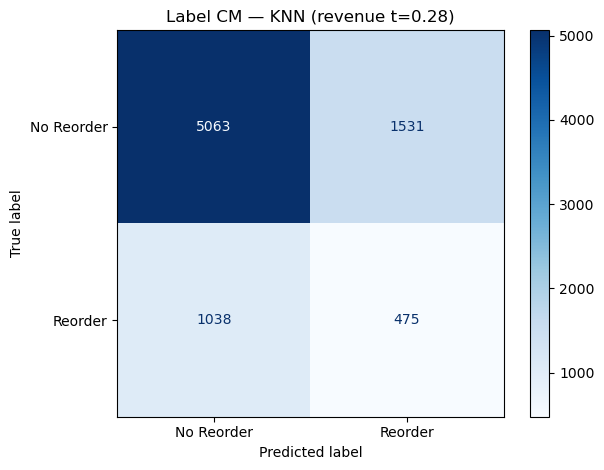

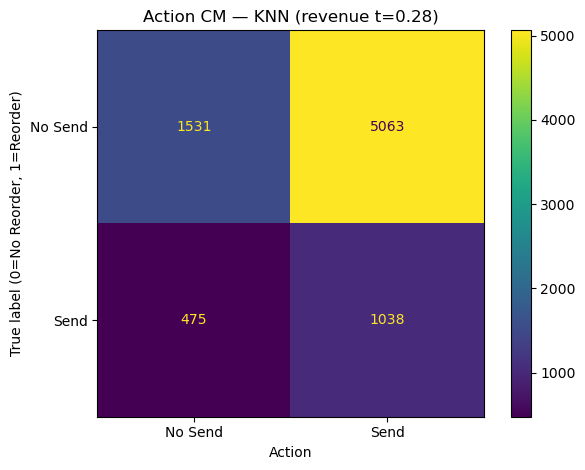

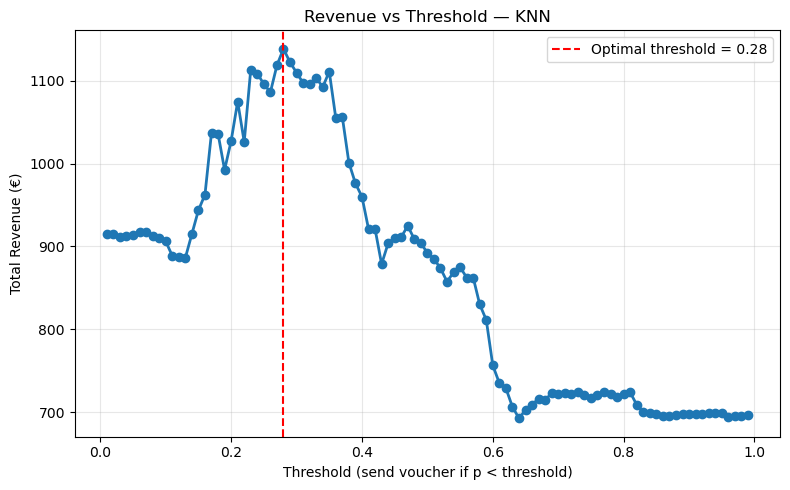

In [139]:
print("Training K-Nearest Neighbors (with StandardScaler)...")

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])

result_knn, model_knn = evaluate_model(knn_pipeline, "KNN", X_train_df, y_train, X_val_df, y_val)
models["KNN"] = model_knn
results.append(result_knn)

print_and_plot_result(result_knn, "KNN")




## 5.6 Now for the Stochastic GB

Training Stochastic GradientBoostingClassifier (subsample<1)...

Training & Evaluating: StochasticGB
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.32      0.01      0.01      1513

    accuracy                           0.81      8107
   macro avg       0.57      0.50      0.45      8107
weighted avg       0.72      0.81      0.73      8107

Default metrics -> Acc: 0.8120 | Prec(1): 0.3226 | Rec(1): 0.0066 | F1(1): 0.0130 | ROC-AUC: 0.6407

Revenue-optimized decision:
Best threshold (revenue): 0.1900
Send-rate @ best t: 0.605
Total Revenue @ best t: €1978.75
Average Revenue @ best t: €0.2441

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.86      0.64      0.74      6594
     Reorder       0.26      0.56      0.36      1513

    accuracy                           0.63      8107
   ma

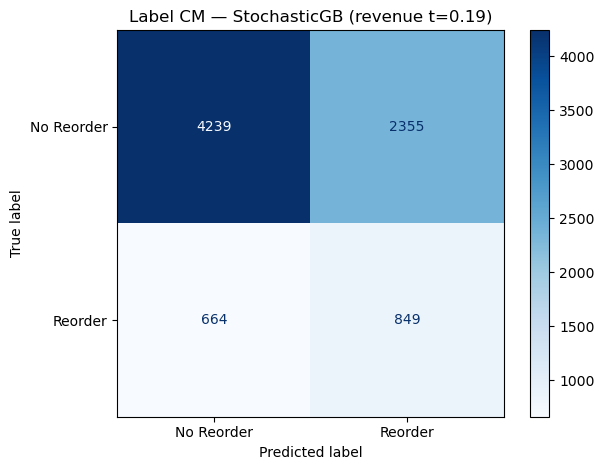

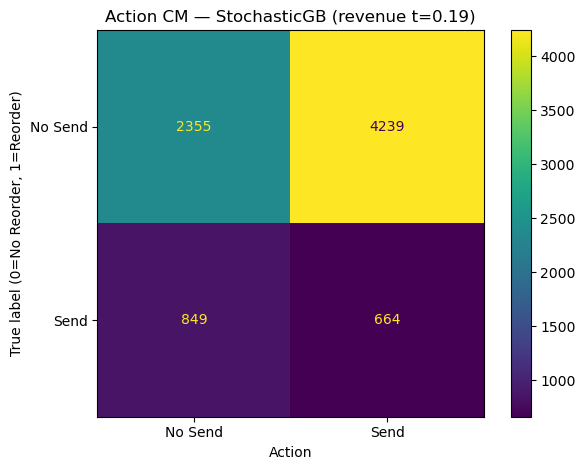

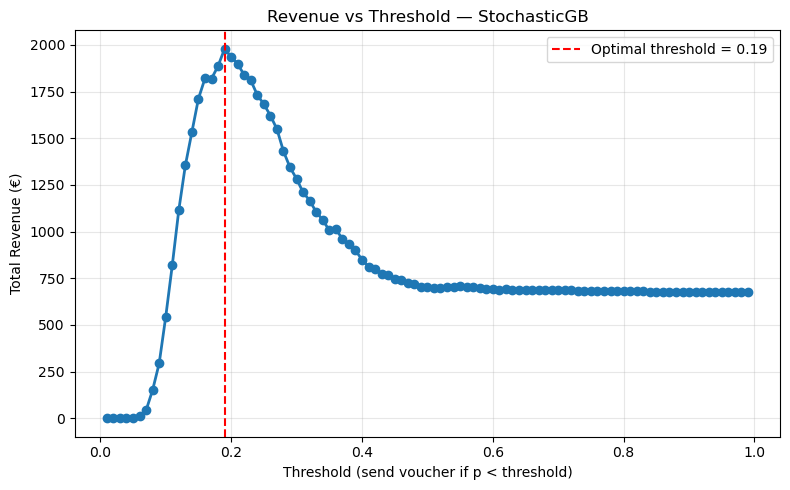

In [140]:
print("Training Stochastic GradientBoostingClassifier (subsample<1)...")

sgb = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

result_sgb, model_sgb = evaluate_model(sgb, "StochasticGB", X_train_df, y_train, X_val_df, y_val)
models["StochasticGB"] = model_sgb
results.append(result_sgb)

print_and_plot_result(result_sgb, "StochasticGB")


## 5.7 AdaBoost

Training AdaBoost...

Training & Evaluating: AdaBoost
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.00      0.00      0.00      1513

    accuracy                           0.81      8107
   macro avg       0.41      0.50      0.45      8107
weighted avg       0.66      0.81      0.73      8107

Default metrics -> Acc: 0.8134 | Prec(1): 0.0000 | Rec(1): 0.0000 | F1(1): 0.0000 | ROC-AUC: 0.6378

Revenue-optimized decision:
Best threshold (revenue): 0.2300
Send-rate @ best t: 0.551
Total Revenue @ best t: €1950.00
Average Revenue @ best t: €0.2405

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.87      0.59      0.70      6594
     Reorder       0.26      0.62      0.36      1513

    accuracy                           0.59      8107
   macro avg       0.56      0.60      0.53      810

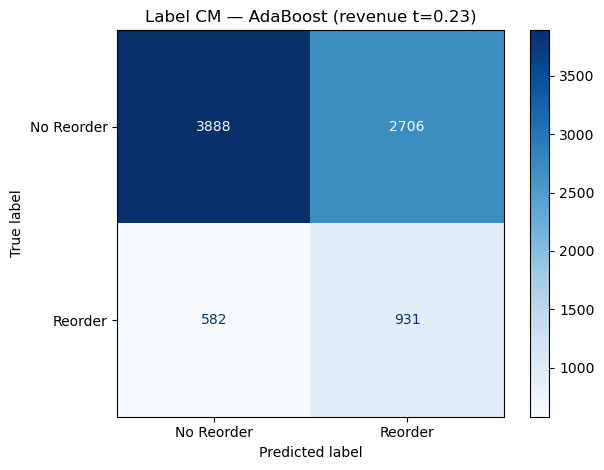

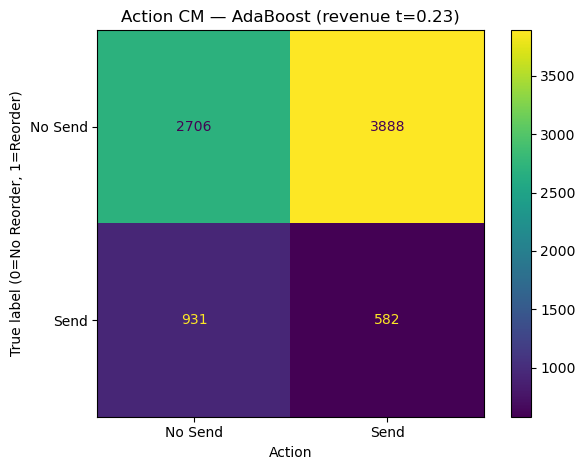

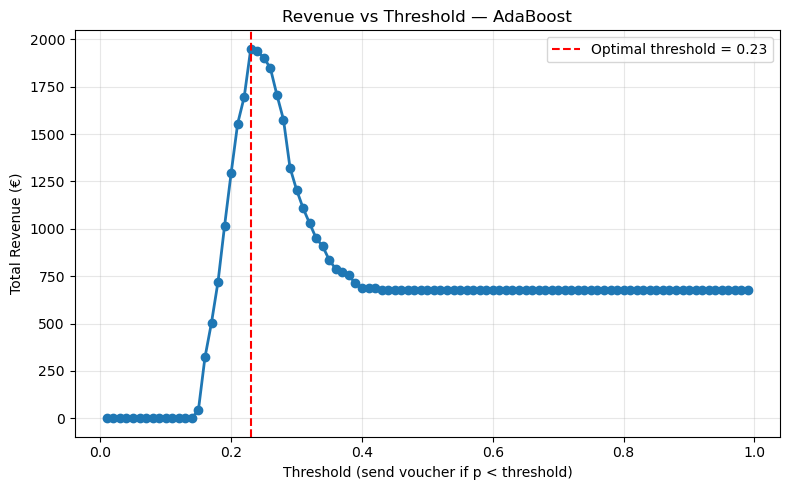

In [141]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print("Training AdaBoost...")

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
    n_estimators=500,
    learning_rate=0.05,
    random_state=RANDOM_STATE
)

result_ada, model_ada = evaluate_model(ada, "AdaBoost", X_train_df, y_train, X_val_df, y_val)
models["AdaBoost"] = model_ada
results.append(result_ada)

print_and_plot_result(result_ada, "AdaBoost")


## Comparison of all models

In [142]:
import pandas as pd
import numpy as np

# Build comparison table from results list
rows = []
for r in results:
    rows.append({
        "model": r.get("model_name", "unknown"),
        "accuracy": r.get("accuracy", np.nan),
        "roc_auc": r.get("roc_auc", np.nan),
        "best_threshold": r.get("best_threshold", np.nan),
        "send_rate": r.get("send_rate", np.nan),
        "total_revenue": r.get("total_revenue", np.nan),
        "avg_revenue": r.get("avg_revenue", np.nan),
    })

cmp_df = pd.DataFrame(rows)

# If you have duplicates (e.g., re-runs), keep the best by total revenue per model name
cmp_df = (cmp_df.sort_values("total_revenue", ascending=False)
                .drop_duplicates(subset=["model"], keep="first")
                .reset_index(drop=True))

# Sort for display (profit-first)
cmp_df = cmp_df.sort_values("total_revenue", ascending=False).reset_index(drop=True)

display(cmp_df)


,model,accuracy,roc_auc,best_threshold,send_rate,total_revenue,avg_revenue
0,HistGradientBoosting,0.813495,0.646917,0.19,0.579623,2055.00,0.253485
1,Gradient Boosting,0.811768,0.641141,0.19,0.604539,1995.00,0.246084
2,StochasticGB,0.812014,0.640722,0.19,0.604786,1978.75,0.244079
3,AdaBoost,0.813371,0.637751,0.23,0.551375,1950.00,0.240533
4,Random Forest,0.657457,0.639309,0.50,0.656593,1947.50,0.240224
5,LightGBM,0.671025,0.617605,0.49,0.670285,1792.50,0.221105
6,Logistic Regression,0.605033,0.620860,0.56,0.782164,1720.00,0.212162
7,KNN,0.780807,0.557458,0.28,0.752560,1138.75,0.140465


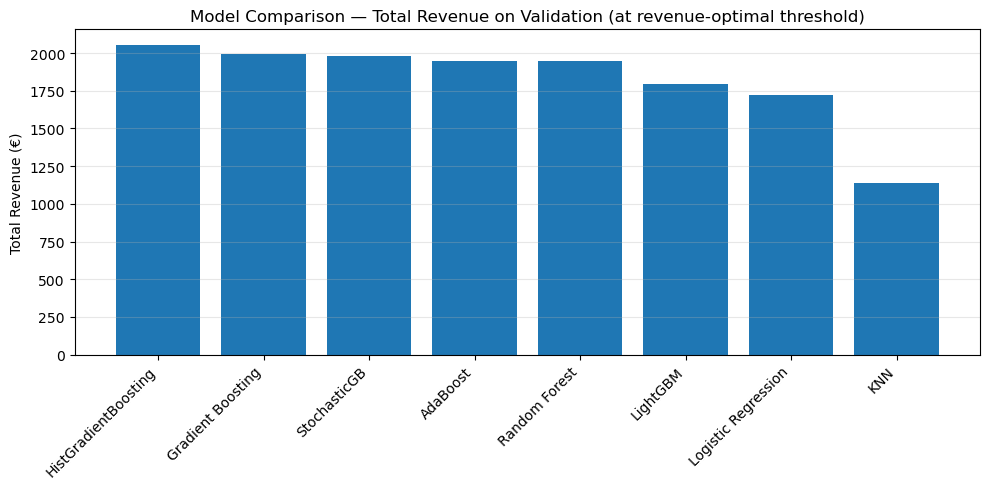

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["total_revenue"])
plt.title("Model Comparison — Total Revenue on Validation (at revenue-optimal threshold)")
plt.ylabel("Total Revenue (€)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


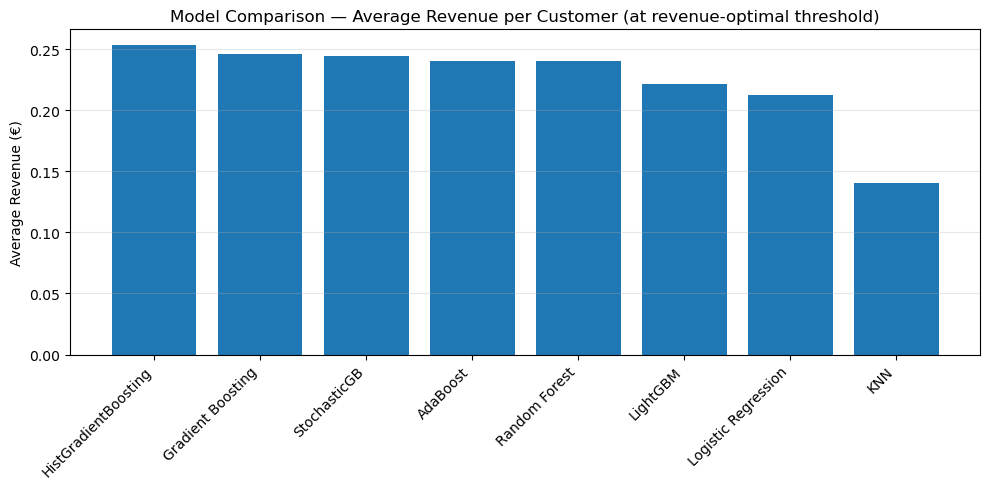

In [144]:
plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["avg_revenue"])
plt.title("Model Comparison — Average Revenue per Customer (at revenue-optimal threshold)")
plt.ylabel("Average Revenue (€)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


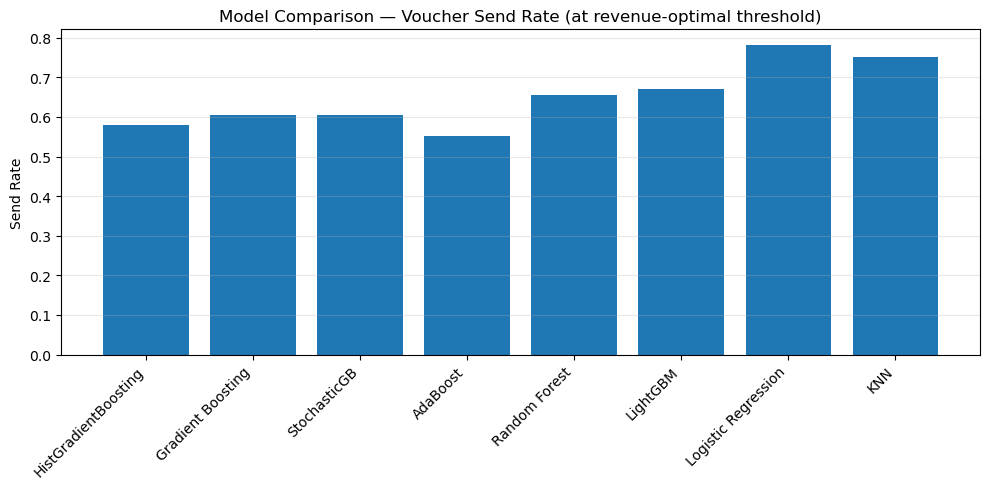

In [145]:
plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["send_rate"])
plt.title("Model Comparison — Voucher Send Rate (at revenue-optimal threshold)")
plt.ylabel("Send Rate")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Hyperparamter tuning of the two best models 

We use a CV scorer that returns max avg revenue per fold (same idea as before) and run a small RandomizedSearchCV (faster and usually as good as grid).

In [146]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np

def revenue_cv_scorer(estimator, X, y):
    # Get probabilities for class 1 (reorder)
    if hasattr(estimator, "predict_proba"):
        p = estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        p = 1 / (1 + np.exp(-s))
    else:
        p = estimator.predict(X).astype(float)

    p = np.clip(p, 0, 1)

    # Choose best threshold on THIS fold and return avg revenue
    t_star, _, _ = optimize_threshold(y, p)
    _, avg_rev, _ = calculate_revenue(y, p, t_star)
    return avg_rev

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)


## 7.1 Tuning  HistGradientBoosting
This was our best model

In [147]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_base = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

param_dist_hgb = {
    "learning_rate": [0.02, 0.03, 0.05, 0.08, 0.1],
    "max_depth": [3, 4, 5, 6, None],
    "max_iter": [200, 300, 400, 600],
    "min_samples_leaf": [10, 20, 40, 80],
    "l2_regularization": [0.0, 0.1, 0.5, 1.0],
}

search_hgb = RandomizedSearchCV(
    estimator=hgb_base,
    param_distributions=param_dist_hgb,
    n_iter=20,
    scoring=revenue_cv_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search_hgb.fit(X_train_df, y_train)

print("HGB best CV avg revenue:", search_hgb.best_score_)
print("HGB best params:", search_hgb.best_params_)

hgb_tuned = search_hgb.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
HGB best CV avg revenue: 0.23169277579046912
HGB best params: {'min_samples_leaf': 10, 'max_iter': 400, 'max_depth': 3, 'learning_rate': 0.05, 'l2_regularization': 0.5}



Training & Evaluating: HistGradientBoosting_Tuned
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.80      0.00      0.01      1513

    accuracy                           0.81      8107
   macro avg       0.81      0.50      0.45      8107
weighted avg       0.81      0.81      0.73      8107

Default metrics -> Acc: 0.8137 | Prec(1): 0.8000 | Rec(1): 0.0026 | F1(1): 0.0053 | ROC-AUC: 0.6446

Revenue-optimized decision:
Best threshold (revenue): 0.2100
Send-rate @ best t: 0.684
Total Revenue @ best t: €2027.50
Average Revenue @ best t: €0.2501

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.86      0.72      0.78      6594
     Reorder       0.28      0.48      0.36      1513

    accuracy                           0.68      8107
   macro avg       0.57      0.60      0.57      8107
w

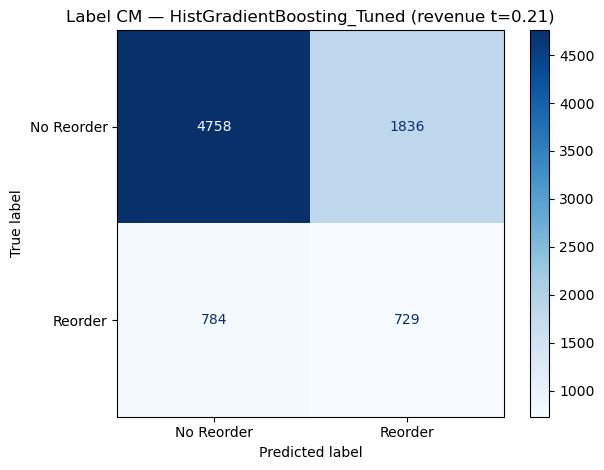

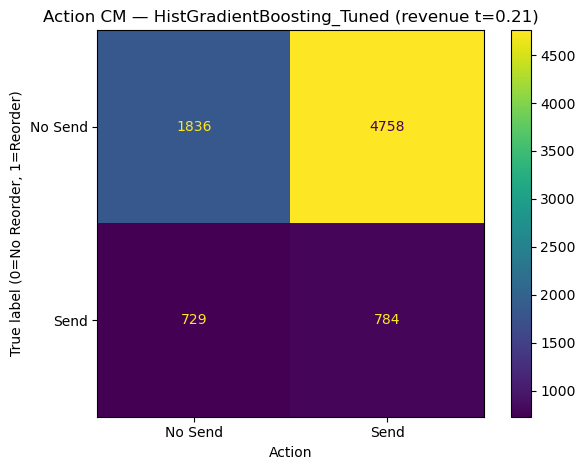

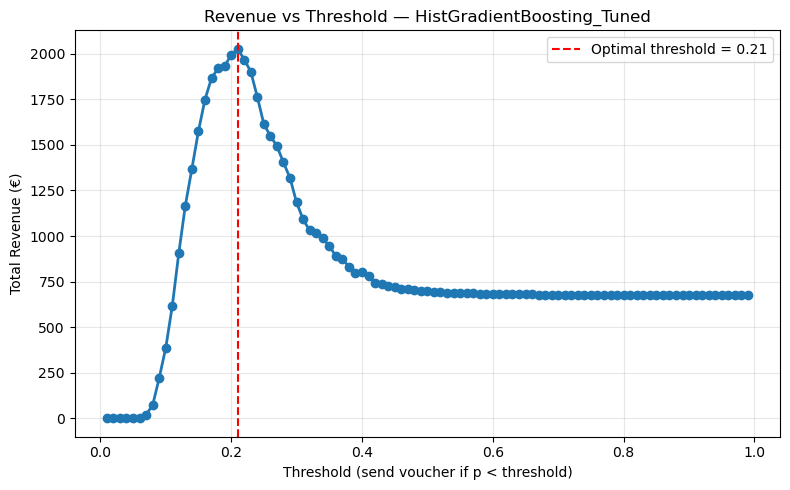

In [148]:
# I store the model 
res_hgb_tuned, mdl_hgb_tuned = evaluate_model(hgb_tuned, "HistGradientBoosting_Tuned", X_train_df, y_train, X_val_df, y_val)
models["HistGradientBoosting_Tuned"] = mdl_hgb_tuned
results.append(res_hgb_tuned)

print_and_plot_result(res_hgb_tuned, "HistGradientBoosting_Tuned")


## Tune StochasticGB

In [149]:
from sklearn.ensemble import GradientBoostingClassifier

sgb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)

param_dist_sgb = {
    "n_estimators": [200, 300, 400, 600],
    "learning_rate": [0.02, 0.03, 0.05, 0.08, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.7, 0.8, 0.9],
    "min_samples_leaf": [1, 2, 5, 10],
    "min_samples_split": [2, 5, 10],
}

search_sgb = RandomizedSearchCV(
    estimator=sgb_base,
    param_distributions=param_dist_sgb,
    n_iter=20,
    scoring=revenue_cv_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search_sgb.fit(X_train_df, y_train)

print("SGB best CV avg revenue:", search_sgb.best_score_)
print("SGB best params:", search_sgb.best_params_)

sgb_tuned = search_sgb.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
SGB best CV avg revenue: 0.23503351013527404
SGB best params: {'subsample': 0.7, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.03}



Training & Evaluating: StochasticGB_Tuned
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.80      0.00      0.01      1513

    accuracy                           0.81      8107
   macro avg       0.81      0.50      0.45      8107
weighted avg       0.81      0.81      0.73      8107

Default metrics -> Acc: 0.8137 | Prec(1): 0.8000 | Rec(1): 0.0026 | F1(1): 0.0053 | ROC-AUC: 0.6439

Revenue-optimized decision:
Best threshold (revenue): 0.2100
Send-rate @ best t: 0.716
Total Revenue @ best t: €1982.50
Average Revenue @ best t: €0.2445

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.85      0.75      0.80      6594
     Reorder       0.29      0.44      0.35      1513

    accuracy                           0.69      8107
   macro avg       0.57      0.60      0.58      8107
weighted 

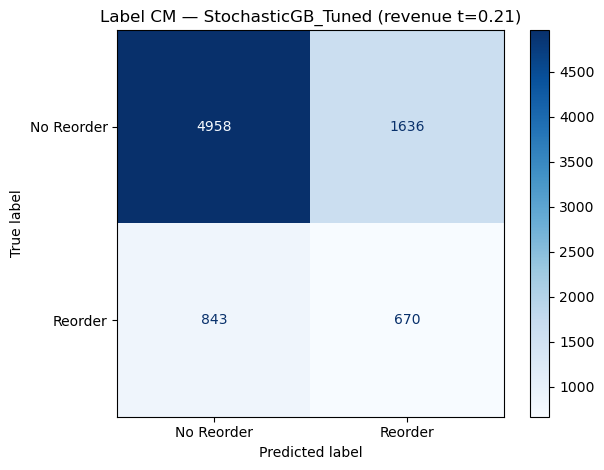

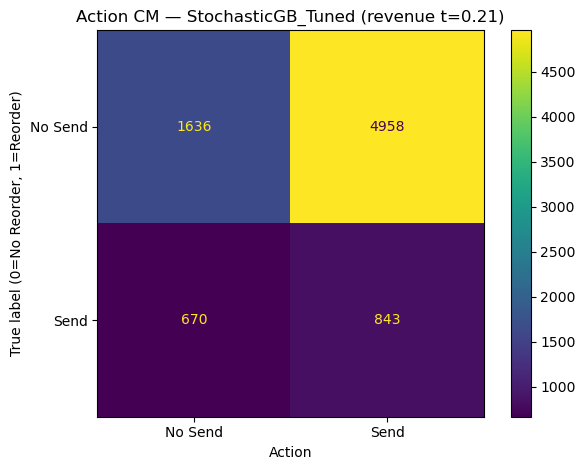

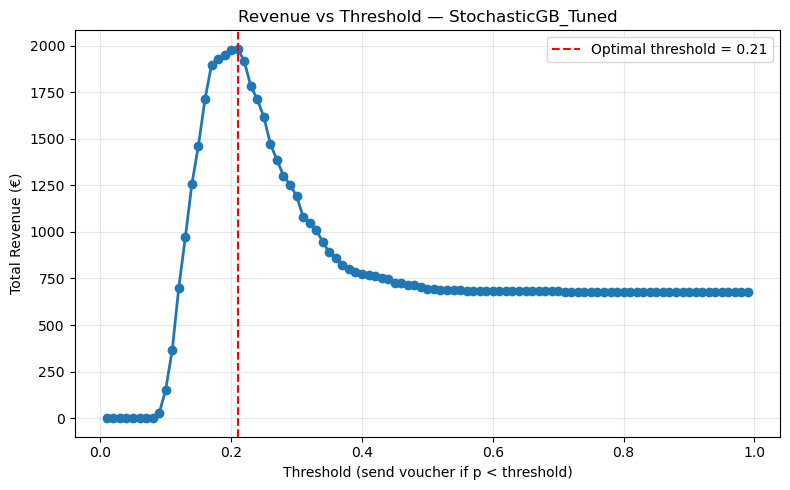

In [150]:
# I store the model 
res_sgb_tuned, mdl_sgb_tuned = evaluate_model(sgb_tuned, "StochasticGB_Tuned", X_train_df, y_train, X_val_df, y_val)
models["StochasticGB_Tuned"] = mdl_sgb_tuned
results.append(res_sgb_tuned)

print_and_plot_result(res_sgb_tuned, "StochasticGB_Tuned")


## 8. Stacking

We start using probability averaging. 
I use the strongest and diverse 2-3 models.

- HistGradientBoosting

- StochasticGB (GradientBoosting with subsample)

- RandomForest (optional third)



In [151]:
from sklearn.base import clone
import numpy as np

base_models = {
    "HistGB": HistGradientBoostingClassifier(
        max_depth=6, learning_rate=0.05, max_iter=400, random_state=RANDOM_STATE
    ),
    "StochasticGB": GradientBoostingClassifier(
        n_estimators=400, learning_rate=0.05, max_depth=3, subsample=0.7,
        min_samples_split=5, min_samples_leaf=2, random_state=RANDOM_STATE
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1
    ),
}

fitted = {}
for name, m in base_models.items():
    fitted[name] = clone(m).fit(X_train_df, y_train)
    print("Fitted:", name)


Fitted: HistGB
Fitted: StochasticGB
Fitted: RandomForest


In [152]:
probas = []
for name, m in fitted.items():
    p = m.predict_proba(X_val_df)[:, 1]   # P(reorder=1)
    probas.append(p)

p_ens = np.mean(probas, axis=0)          # equal-weight average


In [153]:
best_t, best_rev, rev_curve = optimize_threshold(y_val, p_ens)
total_rev, avg_rev, send = calculate_revenue(y_val, p_ens, best_t)

print("Ensemble (avg probs) results")
print(f"Best threshold: {best_t:.4f}")
print(f"Send-rate: {send.mean():.3f}")
print(f"Total revenue: €{total_rev:.2f}")
print(f"Avg revenue: €{avg_rev:.4f}")


Ensemble (avg probs) results
Best threshold: 0.2900
Send-rate: 0.595
Total revenue: €2035.00
Avg revenue: €0.2510


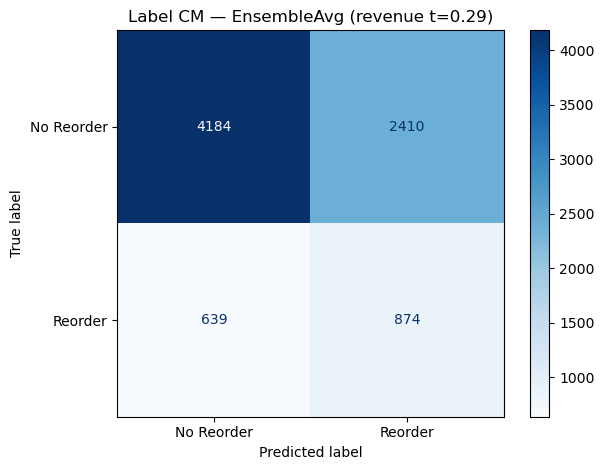

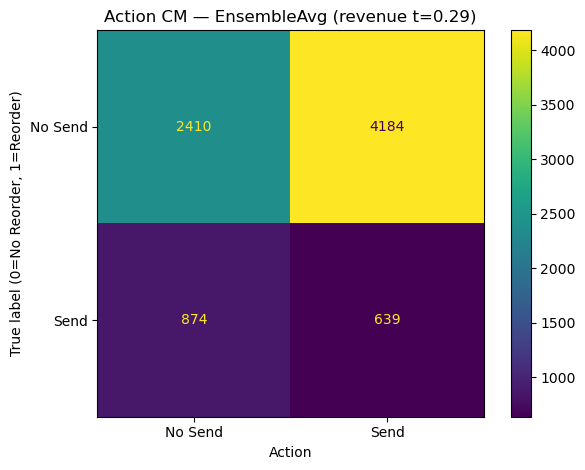

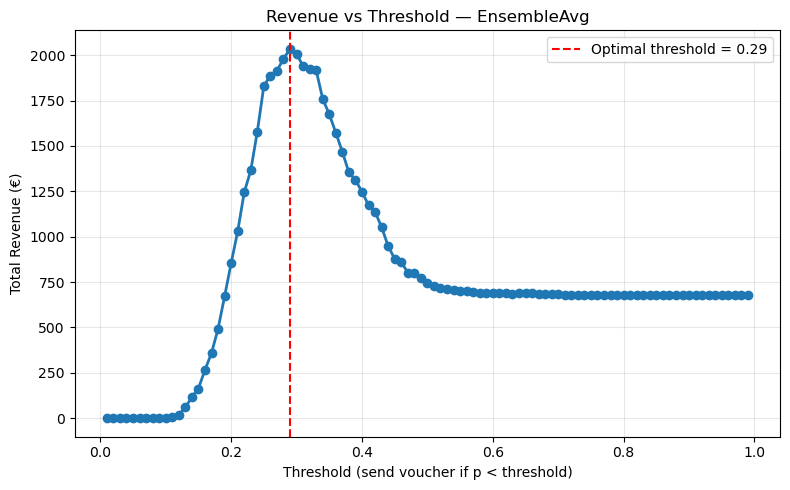

In [154]:
# Label predictions at best threshold
y_pred_best_t = (p_ens >= best_t).astype(int)
send_voucher  = (p_ens < best_t).astype(int)

plot_cm(y_val, y_pred_best_t, f"Label CM — EnsembleAvg (revenue t={best_t:.2f})")
plot_action_cm(y_val, send_voucher, f"Action CM — EnsembleAvg (revenue t={best_t:.2f})")

plt.figure(figsize=(8, 5))
plt.plot(rev_curve["threshold"], rev_curve["total_revenue"], marker="o", linewidth=2)
plt.axvline(best_t, color="red", linestyle="--", label=f"Optimal threshold = {best_t:.2f}")
plt.title("Revenue vs Threshold — EnsembleAvg")
plt.xlabel("Threshold (send voucher if p < threshold)")
plt.ylabel("Total Revenue (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [156]:
ensemble_result = {
    "model_name": "EnsembleAvg_3",
    "accuracy": accuracy_score(y_val, y_pred_best_t),
    "precision": precision_score(y_val, y_pred_best_t, zero_division=0),
    "recall": recall_score(y_val, y_pred_best_t, zero_division=0),
    "f1": f1_score(y_val, y_pred_best_t, zero_division=0),
    "roc_auc": roc_auc_score(y_val, p_ens),
    "report_default": classification_report(y_val, y_pred_best_t, target_names=["No Reorder","Reorder"], zero_division=0),
    "y_pred_default": y_pred_best_t,          # here “default” is not meaningful; but keep for schema
    "best_threshold": best_t,
    "total_revenue": total_rev,
    "avg_revenue": avg_rev,
    "send_rate": float(send_voucher.mean()),
    "y_pred_best_t": y_pred_best_t,
    "send_voucher": send_voucher,
    "y_proba": p_ens,
    "rev_curve": rev_curve,
}
results.append(ensemble_result)
print("Added ensemble to results.")


Added ensemble to results.


# Model comparison (again)

In [157]:
import pandas as pd
import numpy as np

# Build comparison table from results list
rows = []
for r in results:
    rows.append({
        "model": r.get("model_name", "unknown"),
        "accuracy": r.get("accuracy", np.nan),
        "roc_auc": r.get("roc_auc", np.nan),
        "best_threshold": r.get("best_threshold", np.nan),
        "send_rate": r.get("send_rate", np.nan),
        "total_revenue": r.get("total_revenue", np.nan),
        "avg_revenue": r.get("avg_revenue", np.nan),
    })

cmp_df = pd.DataFrame(rows)

# If you have duplicates (e.g., re-runs), keep the best by total revenue per model name
cmp_df = (cmp_df.sort_values("total_revenue", ascending=False)
                .drop_duplicates(subset=["model"], keep="first")
                .reset_index(drop=True))

# Sort for display (profit-first)
cmp_df = cmp_df.sort_values("total_revenue", ascending=False).reset_index(drop=True)

display(cmp_df)

,model,accuracy,roc_auc,best_threshold,send_rate,total_revenue,avg_revenue
0,HistGradientBoosting,0.813495,0.646917,0.19,0.579623,2055.00,0.253485
1,EnsembleAvg_3,0.623905,0.646439,0.29,0.594918,2035.00,0.251018
2,HistGradientBoosting_Tuned,0.813741,0.644595,0.21,0.683607,2027.50,0.250093
3,Gradient Boosting,0.811768,0.641141,0.19,0.604539,1995.00,0.246084
4,StochasticGB_Tuned,0.813741,0.643942,0.21,0.715554,1982.50,0.244542
5,StochasticGB,0.812014,0.640722,0.19,0.604786,1978.75,0.244079
6,AdaBoost,0.813371,0.637751,0.23,0.551375,1950.00,0.240533
7,Random Forest,0.657457,0.639309,0.50,0.656593,1947.50,0.240224
8,LightGBM,0.671025,0.617605,0.49,0.670285,1792.50,0.221105
9,Logistic Regression,0.605033,0.620860,0.56,0.782164,1720.00,0.212162


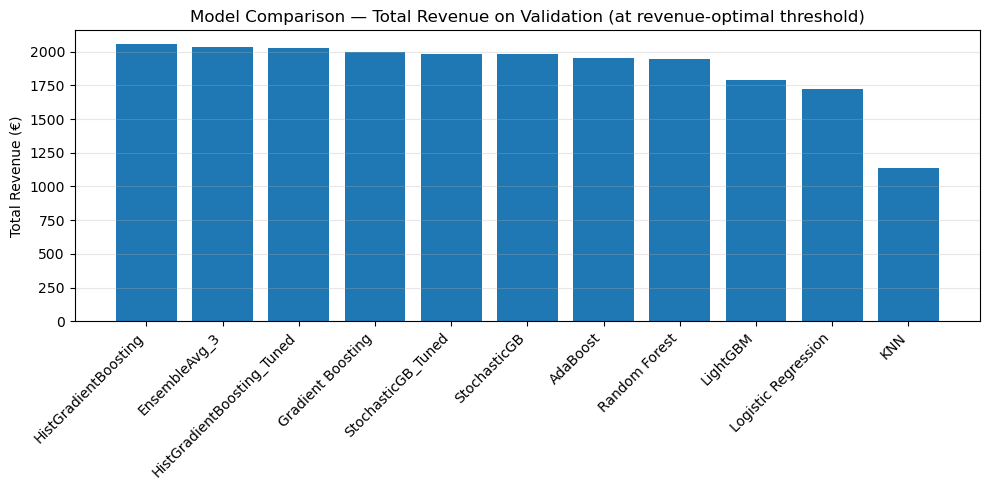

In [158]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["total_revenue"])
plt.title("Model Comparison — Total Revenue on Validation (at revenue-optimal threshold)")
plt.ylabel("Total Revenue (€)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretable Machine Learning

In [124]:
# If shap isn't installed, uncomment:
# !pip install shap -q

import shap
import numpy as np
import pandas as pd

# Pick the model you want to explain:
# Option A (recommended): your best tuned StochasticGB model
model_to_explain = models.get("StochasticGB_Tuned", None)

# Fallback choices if you named it differently:
if model_to_explain is None:
    model_to_explain = models.get("StochasticGB", None)

# If still None, fall back to your best revenue model (adjust key if needed)
if model_to_explain is None:
    model_to_explain = models["HistGradientBoosting"]  # or models["HistGB_Tuned"]

model_name = type(model_to_explain).__name__
print("Explaining model:", model_name)


ModuleNotFoundError: No module named 'shap'

In [ ]:
# Use a subset for SHAP (fast + still representative)
rng = np.random.default_rng(RANDOM_STATE)

# Background sample for the explainer (used to define "baseline")
bg_size = 1000
bg_idx = rng.choice(X_train_df.index, size=min(bg_size, len(X_train_df)), replace=False)
X_bg = X_train_df.loc[bg_idx]

# Explanation sample (the points we compute SHAP for)
explain_size = 2000
ex_idx = rng.choice(X_val_df.index, size=min(explain_size, len(X_val_df)), replace=False)
X_explain = X_val_df.loc[ex_idx]

print("Background shape:", X_bg.shape)
print("Explain shape:", X_explain.shape)


Background shape: (1000, 65)
Explain shape: (2000, 65)


In [ ]:
# We explain the probability of class 1 (Reorder)
def predict_proba_class1(m, X):
    return m.predict_proba(X)[:, 1]

# Try fast TreeExplainer first (works well for sklearn RF/ET/GB)
try:
    explainer = shap.TreeExplainer(model_to_explain, data=X_bg, feature_perturbation="interventional")
    shap_values = explainer.shap_values(X_explain)
    print("Used TreeExplainer.")
except Exception as e:
    print("TreeExplainer failed, falling back to shap.Explainer. Error:", e)
    # General fallback (can be slower, but should work)
    explainer = shap.Explainer(lambda X: predict_proba_class1(model_to_explain, X), X_bg)
    shap_values = explainer(X_explain).values
    print("Used generic shap.Explainer fallback.")

# If TreeExplainer returns a list for classes, take class 1
if isinstance(shap_values, list):
    # For some classifiers, shap_values[1] corresponds to class 1
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

shap_values_class1 = np.array(shap_values_class1)
print("SHAP values shape:", shap_values_class1.shape)


Used TreeExplainer.
SHAP values shape: (2000, 65)


## Beeswarm plot

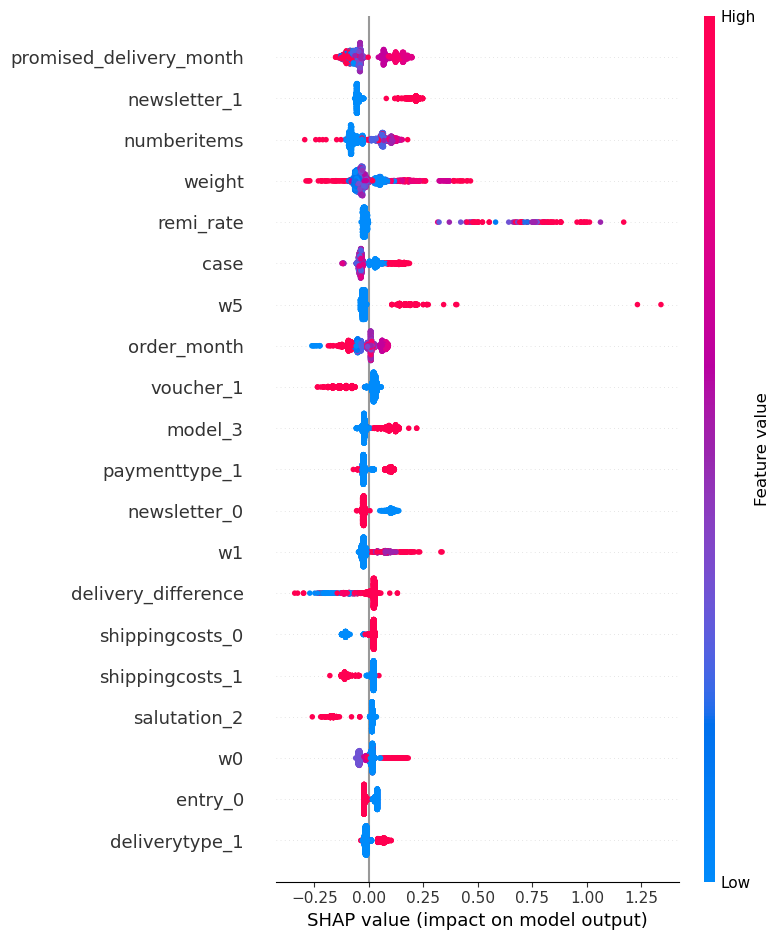

In [ ]:
shap.summary_plot(shap_values_class1, X_explain, show=True)


Interpretation in your context:

The plot ranks features by overall impact (top = most influential).

Each dot is a customer.

Right side (positive SHAP) → increases reorder probability → voucher less justified.

Left side (negative SHAP) → decreases reorder probability → voucher more justified.

Color shows feature value (red=high, blue=low), helping you see whether high values increase or decrease reorder probability.

## Global importance bar

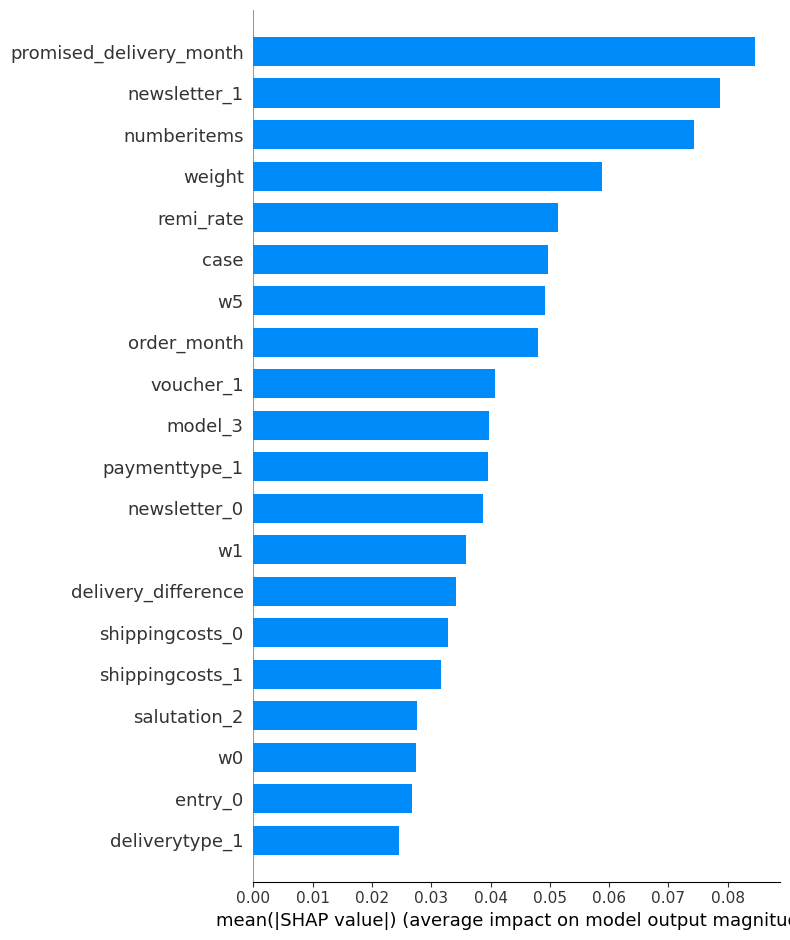

In [ ]:
shap.summary_plot(shap_values_class1, X_explain, plot_type="bar", show=True)


A ranked list of the features with the largest average absolute impact on predicted reorder probability.

This does not show direction (up/down), only magnitude.

## Dependence plot for top fetaures

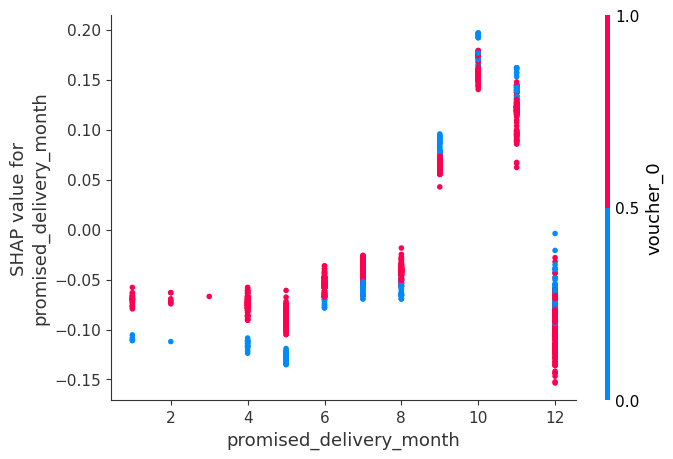

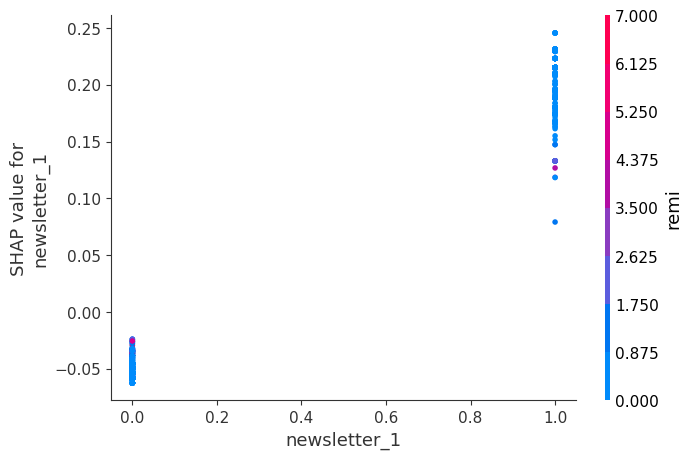

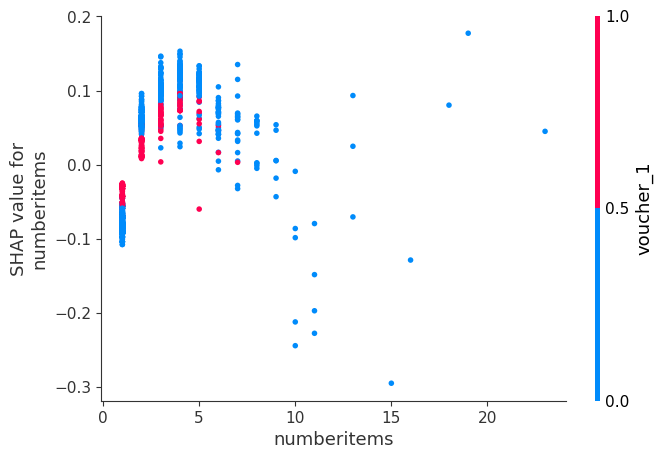

In [ ]:
# Pick top 3 features from mean |SHAP|
mean_abs = np.abs(shap_values_class1).mean(axis=0)
top_features = X_explain.columns[np.argsort(mean_abs)[::-1][:3]].tolist()
top_features

for f in top_features:
    shap.dependence_plot(f, shap_values_class1, X_explain, show=True)


X-axis is the feature value.

Y-axis is SHAP impact on P(reorder=1).

If the curve is mostly negative for certain values, those values push reorder probability down → those customers are more likely to be targeted with vouchers (given your rule).

## Waterfall plot for one customer

In [ ]:
best_t = None
# If you stored the best threshold in results, choose the correct one:
# Replace "StochasticGB_Tuned" with whichever model you explained.
for r in results:
    if r.get("model_name") in ["StochasticGB_Tuned", "StochasticGB", "HistGB_Tuned", "HistGradientBoosting"]:
        if type(model_to_explain).__name__ in r.get("model_name", "") or r.get("model_name") in ["StochasticGB_Tuned", "StochasticGB"]:
            best_t = r.get("best_threshold", None)
            break

# If not found, set manually to your chosen model's best threshold from table
if best_t is None:
    best_t = 0.19  # adjust if needed

p_all = model_to_explain.predict_proba(X_val_df)[:, 1]
send_mask = p_all < best_t

# pick one "send" example and one "no send" example
idx_send = X_val_df.index[np.where(send_mask)[0][0]]
idx_nosend = X_val_df.index[np.where(~send_mask)[0][0]]

idx_send, idx_nosend, best_t


(30948, 7983, 0.19)

Example SEND: p(reorder)= 0.152 < t=0.19 -> send voucher


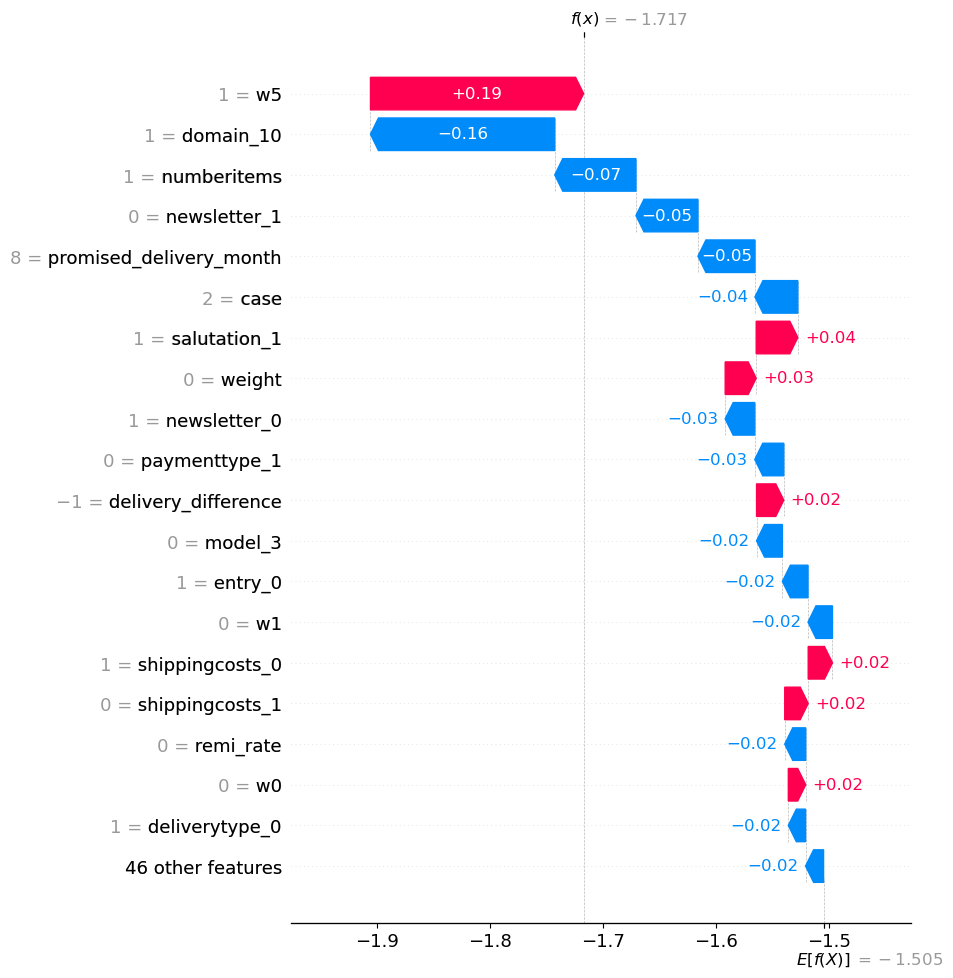

In [ ]:
# Waterfall for a SEND decision
x1 = X_val_df.loc[[idx_send]]
p1 = model_to_explain.predict_proba(x1)[:, 1][0]
print(f"Example SEND: p(reorder)= {p1:.3f} < t={best_t:.2f} -> send voucher")

# Compute shap for this single row
sv1 = explainer.shap_values(x1)
if isinstance(sv1, list):
    sv1 = sv1[1]
sv1 = np.array(sv1).reshape(-1)

base = explainer.expected_value
if isinstance(base, (list, np.ndarray)):
    base = base[1] if len(base) > 1 else base[0]

exp1 = shap.Explanation(values=sv1, base_values=base, data=x1.iloc[0], feature_names=x1.columns)
shap.plots.waterfall(exp1, max_display=20)


## Predictions on the test set

In [ ]:
# Choose final model (best by validation revenue among tuned models)
final_model = models["HistGB_Tuned"]   # change if your key differs
final_threshold = 0.19                # from your tuned validation result

print("Final model:", type(final_model).__name__)
print("Final threshold:", final_threshold)


Final model: HistGradientBoostingClassifier
Final threshold: 0.19


In [ ]:
# Combine train and validation for final training
X_full = pd.concat([X_train_df, X_val_df], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

final_model.fit(X_full, y_full)
print("Final model refit on full labeled data:", X_full.shape)


Final model refit on full labeled data: (32428, 65)


In [ ]:
# If you already have X_test_df, this will just show shape
X_test_df.shape


(32427, 65)

In [ ]:
# Predict probability of reorder=1
p_test = final_model.predict_proba(X_test_df)[:, 1]

# Apply voucher rule: send if p(reorder) < threshold
send_voucher = (p_test < final_threshold).astype(int)

# Optional: predicted reorder label under threshold
pred_label = (p_test >= final_threshold).astype(int)

# Load raw test again if needed to get customernumber
# (Assumes your raw test df still has customernumber)
if "customernumber" not in test.columns:
    test = pd.read_csv("test.csv", sep=";")

submission = pd.DataFrame({
    "customernumber": test["customernumber"].values,
    "p_reorder": p_test,
    "send_voucher": send_voucher,
    "pred_label": pred_label
})

submission.head(), submission.shape


(   customernumber  p_reorder  send_voucher  pred_label
 0            6044   0.122088             1           0
 1           36314   0.228443             0           1
 2           41932   0.328798             0           1
 3            3194   0.126046             1           0
 4           35363   0.116314             1           0,
 (32427, 4))

In [ ]:
out_path = "submission.csv"
submission.to_csv(out_path, index=False)
print("Saved:", out_path)


Saved: submission.csv
